<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 4

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* [Car figure](https://korkortonline.se/en/theory/reaction-braking-stopping/)
* [Correlation coefficient figure](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Probability: multivariate models
    - The multivariate Gaussian: joint pdf, conditional pdf and marginal pdf
    - Covariance and covariance matrix

**Reading material**: This notebook (+ Bishop's book Section 2.3)

In [2]:
# This cell is hidden during presentation. It's just to define a function to plot the governing model of
# the car stopping distance problem. Defining a function that creates a plot allows to repeatedly run
# this function on cells used in this notebook.
def car_fig(ax):
    real_x = np.linspace(3, 83, 1000)
    real_mu_y = 1.5*real_x + 0.1*(real_x**2) # Recall: E[z*x+0.1*x^2] = E[z]*E[x]+0.1*E[x^2]
    real_sigma_y = np.sqrt( 0.5**2*real_x**2 ) # Recall: V[z*x+x^2] = V[z*x]+V[x^2]=...=sigma_z^2+mu_x^2
    ax.set_xlabel("x (m/s)", fontsize=20) # create x-axis label with font size 20
    ax.set_ylabel("y (m)", fontsize=20) # create y-axis label with font size 20
    ax.set_title("Car stopping distance problem", fontsize=20); # create title with font size 20
    ax.plot(real_x, real_mu_y, 'k:', label="Governing model $\mu_y$")
    ax.fill_between(real_x, real_mu_y - 1.9600 * real_sigma_y,
                    real_mu_y + 1.9600 * real_sigma_y,
                    color='k', alpha=0.2,
                    label='95% confidence interval ($\mu_y \pm 1.96\sigma_y$)') # plot 95% credence interval
    ax.legend(fontsize=15)

## Summary of Bayes' rule
$\require{color}$
$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)} = \frac{ {\color{magenta}p(y=\mathcal{D}_y, z)} } {p(y=\mathcal{D}_y)}
$$

* ${\color{red}p(z)}$ is the **prior** distribution
* ${\color{blue}p(y=\mathcal{D}_y|z)}$ is the **likelihood** function
* ${\color{magenta}p(y=\mathcal{D}_y, z)}$ is the **joint likelihood** (product of likelihood function with prior distribution)
* $p(y=\mathcal{D}_y)$ is the **marginal likelihood**
* ${\color{green}p(z|y=\mathcal{D}_y)}$ is the **posterior**

We can write Bayes' rule as <font color='green'>posterior</font> $\propto$ <font color='blue'>likelihood</font> $\times$ <font color='red'>prior </font>, where we are ignoring the denominator $p(y=\mathcal{D}_y)$ because it is just a **constant** independent of the hidden variable $z$.

## Diving deeper into the joint pdf

Later we will dedicate a lot of effort to using Bayes' rule to update a distribution over unknown values of
some quantity of interest, given relevant observed data $\mathcal{D}_y$.

This is what is called *Bayesian inference* (a.k.a. *posterior inference*).

* But before we do that, we need to understand very well multivariate pdfs.
    - In particular, let's focus on the most important one: the **multivariate Gaussian**

## Multivariate Gaussian <a title="probability density function">pdf</a> (a.k.a. <a title="Multivariate normal">MVN</a> distribution)

The multivariate Gaussian <a title="probability density function">pdf</a> of a $D$-dimensional vector $\mathbf{x}$ is given by,

$$
\begin{align}
p(\mathbf{x}|\boldsymbol{\mu},\boldsymbol{\Sigma}) & = \frac{e^{\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(x-\mu)}}{\sqrt{(2\pi)^D |\boldsymbol{\Sigma}|}} \\
& = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left[ \frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right]
\end{align}
$$

where $\boldsymbol{\mu}=\mathbb{E}[\mathbf{x}]\in \mathbb{R}^D$ is the mean vector, and $\boldsymbol{\Sigma}= \text{Cov}[\mathbf{x}]$ is the $D\times D$ **covariance matrix**. 

### Covariance matrix

The covariance matrix is a natural generalization of the variance (Lecture 1) for the multivariate case!

$$
\begin{align}
\boldsymbol{\Sigma} = \text{Cov}[\mathbf{x}] &= \mathbb{E}\left[(\mathbf{x}-\mathbb{E}[\mathbf{x}])(\mathbf{x}-\mathbb{E}[\mathbf{x}])^T \right] \\
 &= \begin{bmatrix}
\mathbb{V}[x_1] & \text{Cov}[x_1,x_2] & \cdots & \text{Cov}[x_1, x_D] \\
\text{Cov}[x_2,x_1] & \mathbb{V}[x_2] & \cdots & \text{Cov}[x_2, x_D] \\
\vdots          & \vdots & \ddots & \vdots \\
\text{Cov}[x_D,x_1] & \text{Cov}[x_D,x_2] & \cdots & \mathbb{V}[x_D] \\
\end{bmatrix}
\end{align}
$$

where $\text{Cov}[x_i,x_j] = \mathbb{E}\left[(x_i-\mathbb{E}[x_i])(x_j-\mathbb{E}[x_j])\right] = \mathbb{E}[x_i x_j] - \mathbb{E}[x_i][x_j]$

Also note that $\mathbb{V}[x_i]=\text{Cov}[x_i,x_i]$.

#### Notes about covariance and normalized covariance (correlation coefficient)

The covariance between two rv's $y$ and $z$ measures the degree to which $y$ and $z$ are **linearly** related.

Covariances can be between negative and positive infinity.

Sometimes it is more convenient to work with a normalized measure, with a finite lower and upper bound. The (Pearson) **correlation coefficient** between $y$ and $z$ is defined as

$$
\rho = \text{corr}[y,z] = \frac{\text{Cov}[y,z]}{\sqrt{\mathbb{V}[y]\mathbb{V}[z]}}
$$

Covariance and correlation coefficient measure the same relationship.

#### Note about normalized covariance (correlation coefficient)

Several sets of $(y_i, z_i)$ points, with the correlation coefficient of $y$ and $z$ for each set.

<img src="docs/Correlation_examples2.svg" title="Correlation coefficient" width="65%" align="right">
Top row: $\text{corr}[y,z]$ reflects the noisiness and direction of a linear relationship.

Middle row: $\text{corr}[y,z]$ **does not** reflect the slope of that relationship

Bottom row: $\text{corr}[y,z]$ **does not** reflect many aspects of nonlinear relationships.

(Additional note: the figure in the center has a slope of 0 but in that case the correlation coefficient is undefined because the variance of $z$ is zero.)

## Understanding the MVN pdf (a common joint pdf)

$$
\begin{align}
p(\mathbf{x}|\boldsymbol{\mu},\boldsymbol{\Sigma}) & = \frac{e^{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(x-\mu)}}{\sqrt{(2\pi)^D |\boldsymbol{\Sigma}|}} \\
& = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left[ -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right]
\end{align}
$$

where $\boldsymbol{\mu}=\mathbb{E}[\mathbf{x}]\in \mathbb{R}^D$ is the mean vector, and $\boldsymbol{\Sigma}= \text{Cov}[\mathbf{x}]$ is the $D\times D$ **covariance matrix**. 

* Multivariate Gaussian pdf's are very important in ML and Statistics.

* Let's discover their properties by working out some examples.

### Exercise 1: MVN from independent Gaussian rv's

Consider two **independent** rv's $x_1$ and $x_2$ where each of them is a univariate Gaussian pdf:

$$
x_1 = \mathcal{N}(x_1|\mu_{x_1}, \sigma_{x_1}^2)
$$

$$
x_2 = \mathcal{N}(x_2|\mu_{x_2}, \sigma_{x_2}^2)
$$

where $\mu_{x_1}=10$, $\sigma_{x_1}^2=5^2$, $\mu_{x_2}=0.5$ and $\sigma_{x_2}^2=2^2$.

Answer the following questions:

1. What is the joint pdf $p(x_1, x_2)$?

2. Calculate the covariance matrix for $\mathbf{x}=\begin{bmatrix}x_1\\x_2\end{bmatrix}$.

Once you finish, let's plot the joint pdf.

In [3]:
# This code is hidden during presentation (shown as notes).
from scipy.stats import norm # import from scipy.stats the normal distribution
from matplotlib.gridspec import GridSpec # for more control over subplots that have 2D and 3D axes
#from matplotlib import cm 

mu_x1 = 10.0; sigma_x1 = 0.5; # parameters of p(x1)
mu_x2 = 0.5; sigma_x2 = 2.0 # parameters of p(x2)

# Since x1 and x2 are independent, we don't even need to call multivariate_normal from scipy.stats
N_samples = 300 # number of samples
x1range = np.linspace(-3*sigma_x1+mu_x1, 3*sigma_x1+mu_x1, N_samples) # x1 values for plotting
x2range = np.linspace(-3*sigma_x2+mu_x2, 3*sigma_x2+mu_x2, N_samples) # x2 values for plotting
samples_x1 = norm.rvs(mu_x1, sigma_x1, size=N_samples) # sample from p(x1)
samples_x2 = norm.rvs(mu_x2, sigma_x2, size=N_samples) # sample from p(x2)

# This figure is created such that the histograms seem a projection of the 3D plot
# I used a simple trick of creating a grid of 3x3 subplots and assigning a 2x2 grid to the 3D plot alone
fig_joint_pdf_ex1 = plt.figure()
gs = GridSpec(3, 3) # to handle subplot placement easier

# Subplot with a 3D surface of the joint pdf p(y,z):
ax_joint_pdf_ex1 = fig_joint_pdf_ex1.add_subplot(gs[1:,1:], projection='3d')
ax_joint_pdf_ex1.set_facecolor('white') # set background for this subplot
x1_grid,x2_grid = np.meshgrid(x1range,x2range) # grid for surface plot
joint_pdf_grid_ex1 = norm.pdf(x1_grid,mu_x1,sigma_x1)*norm.pdf(x2_grid,mu_x2,sigma_x2) # joint pdf values
ax_joint_pdf_ex1.plot_wireframe(x1_grid, x2_grid, joint_pdf_grid_ex1, color = 'grey', alpha=0.5) # surface plot
ax_joint_pdf_ex1.scatter(samples_x1,samples_x2,np.zeros(N_samples), alpha = .7, s = 10) # samples in the z-y plane
ax_joint_pdf_ex1.scatter(np.mean(samples_x1), np.mean(samples_x2), marker = "x", c = "r", s=50) # show the mean
ax_joint_pdf_ex1.set_xlabel(r"$x_1$", fontsize=20)
ax_joint_pdf_ex1.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_ex1.set_ylabel(r"$x_2$", fontsize=20)
ax_joint_pdf_ex1.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_ex1.set_zlabel(r"$p(x_1,x_2)$", fontsize=20)
ax_joint_pdf_ex1.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_ex1.set_xlim3d(-3*sigma_x1+mu_x1,3*sigma_x1+mu_x1) # x1 axis limits
ax_joint_pdf_ex1.set_ylim3d(-3*sigma_x2+mu_x2,3*sigma_x2+mu_x2) # x2 axis limits
#ax_joint_pdf.set_title("Joint probability: $p(y,z)$ [for fixed x=75]", fontsize=20)

# Remind the histogram and pdf for z
ax_hist_x1_ex1 = fig_joint_pdf_ex1.add_subplot(gs[0,2])
ax_hist_x1_ex1.hist(samples_x1, bins='auto', density=True, label='Histogram $p(x_1)$')  
ax_hist_x1_ex1.plot(x1range, norm.pdf(x1range, mu_x1, sigma_x1), 'k--', linewidth = 3, label='$p(x_1)$')
ax_hist_x1_ex1.set_xlabel("$x_1$", fontsize=20)
ax_hist_x1_ex1.set_ylabel("probability density", fontsize=20)
ax_hist_x1_ex1.legend(fontsize=15, loc='upper left');

# Create the histogram and pdf for y|z again (to remind about the scaling)
ax_hist_x2_ex1 = fig_joint_pdf_ex1.add_subplot(gs[1,0]) # place it in position [1,0] in the 3x3 grid
ax_hist_x2_ex1.hist(samples_x2, bins='auto', density=True, label='Histogram $p(x_2)$')  
ax_hist_x2_ex1.plot(x2range, norm.pdf(x2range, mu_x2, sigma_x2),
               'k--', linewidth = 3, label='$p(x_2)$')
ax_hist_x2_ex1.set_xlabel("$x_2$", fontsize=20)
ax_hist_x2_ex1.set_ylabel("probability density", fontsize=20)
ax_hist_x2_ex1.legend(fontsize=15, loc='upper left');

# Create figure with specified size but close it so that we open the figure just for presentation
fig_joint_pdf_ex1.set_size_inches(25, 15) # scale figure to be wider (since there are 2 subplots)
plt.close(fig_joint_pdf_ex1) # do not plot the figure now. We will show it in a later cell

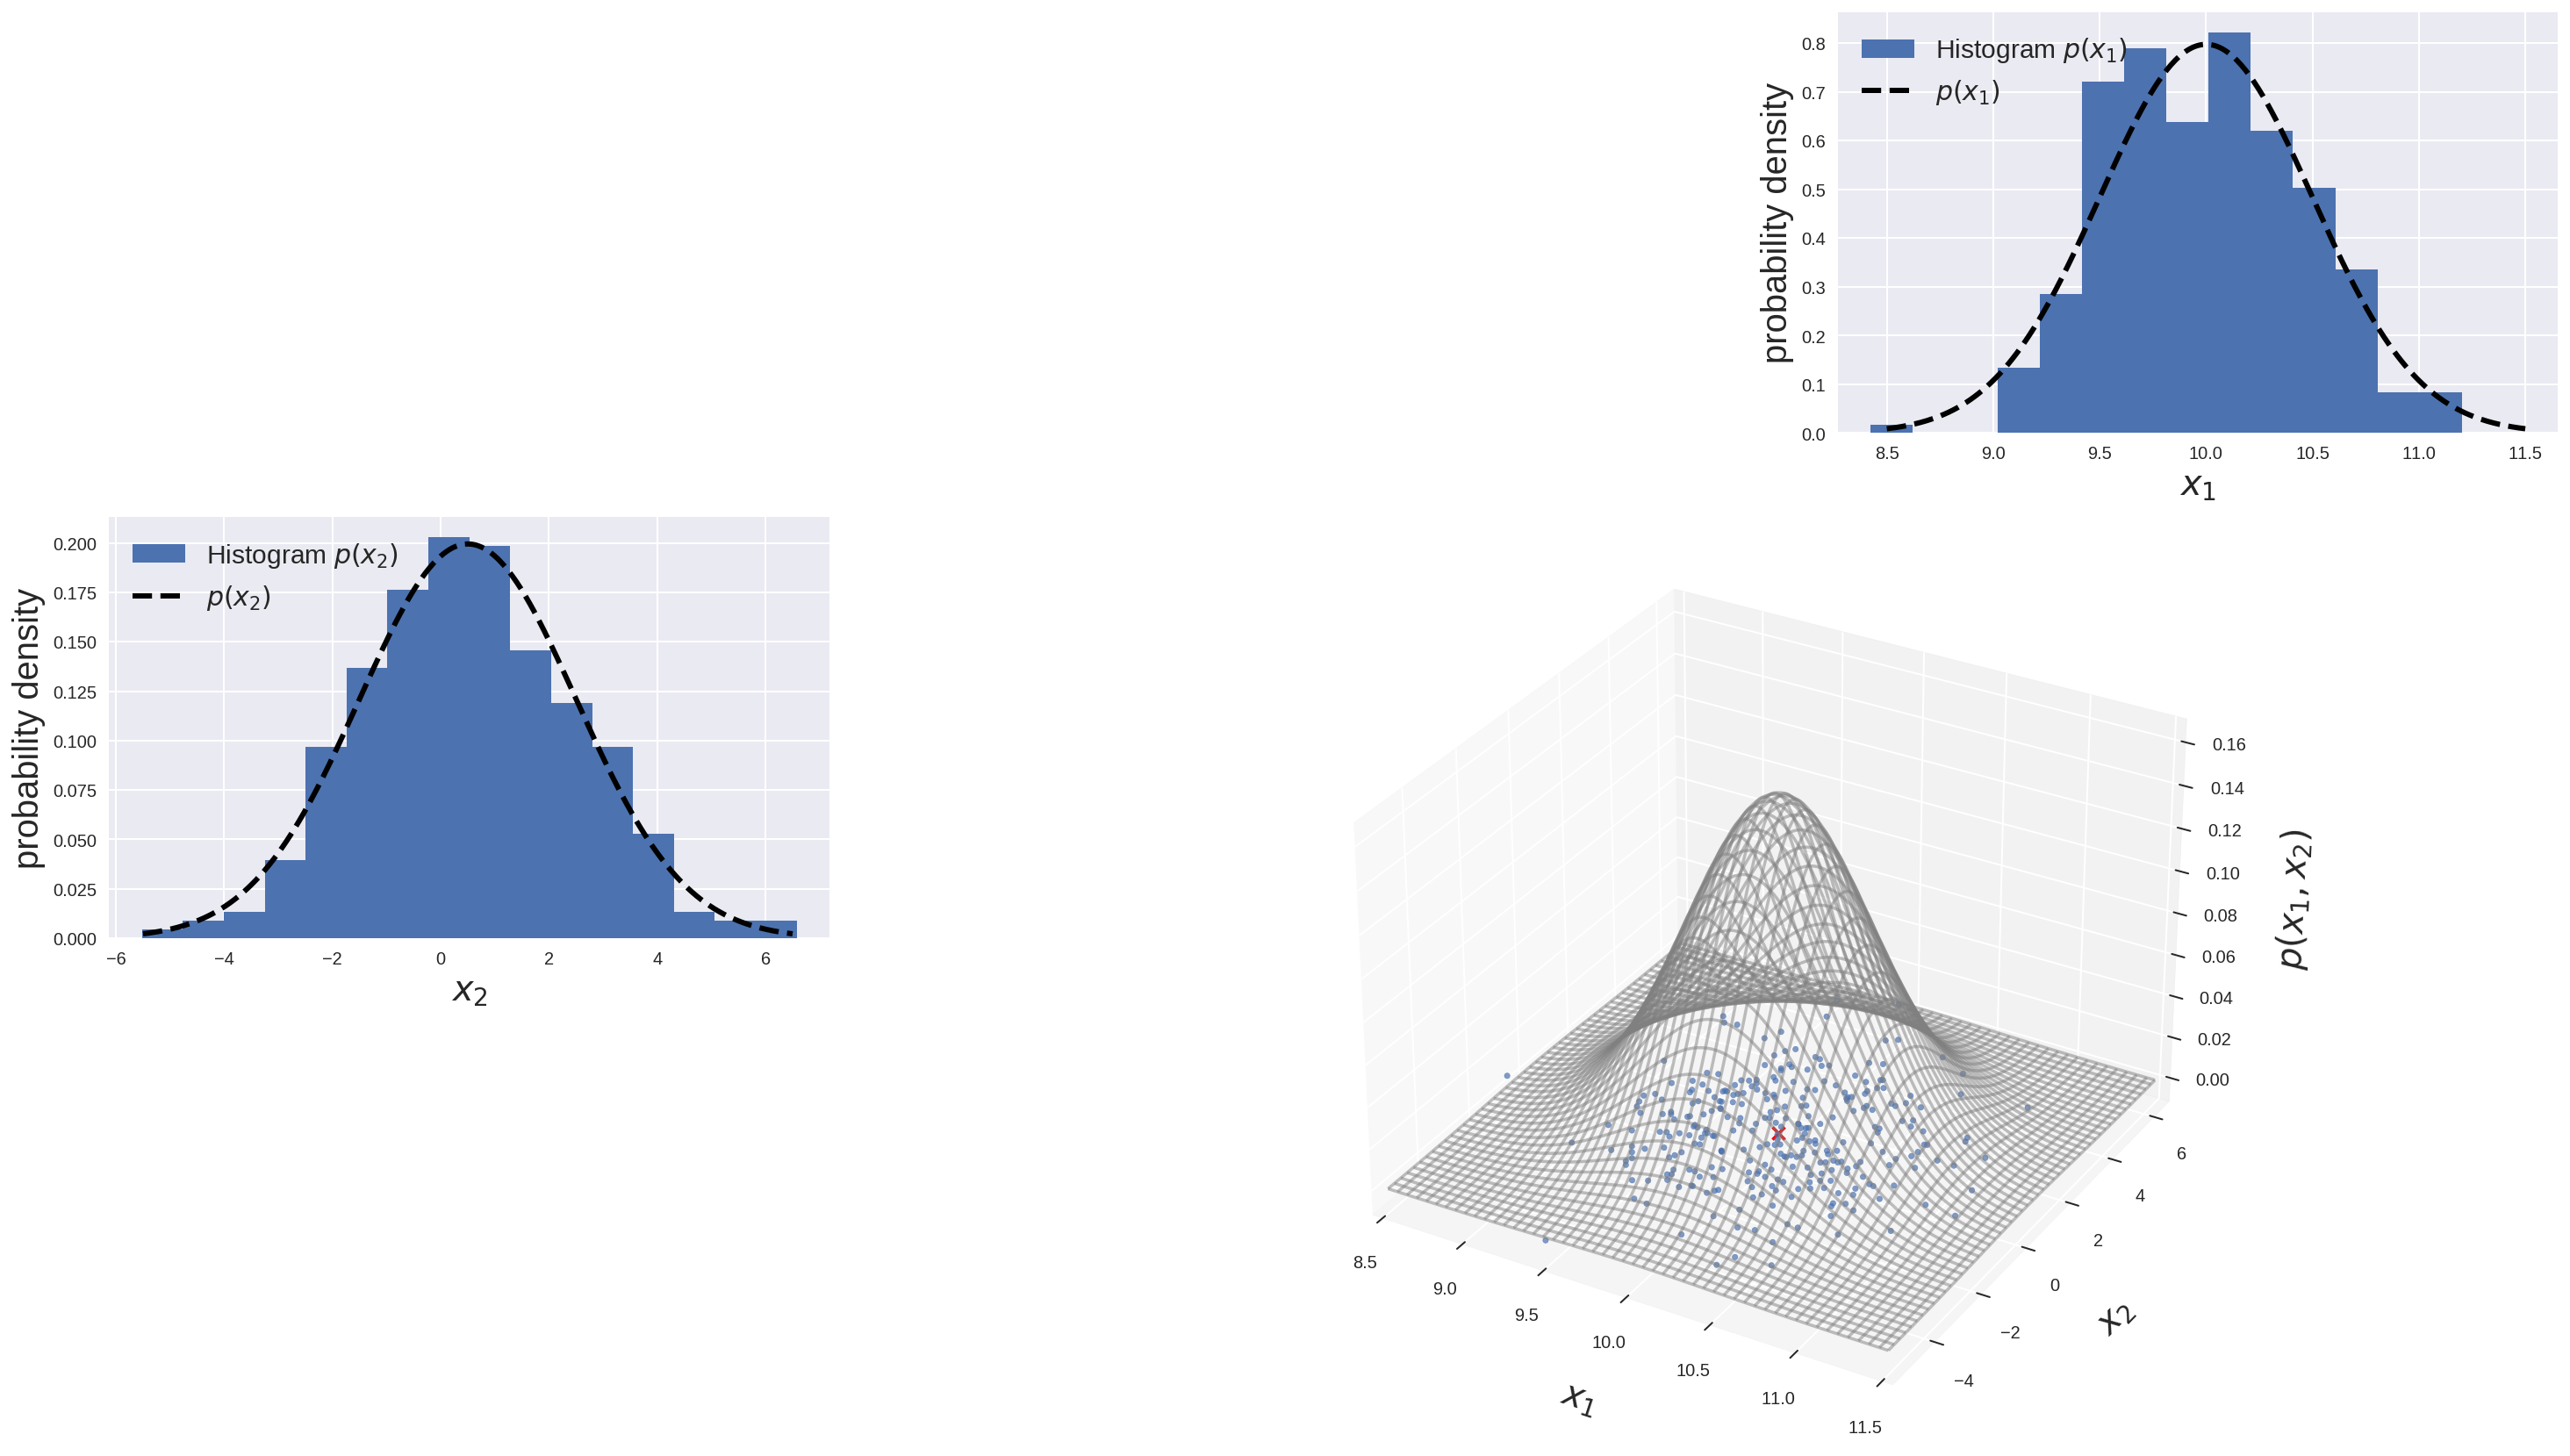

In [4]:
# HIGHLIGHT DIFFERENCE IN MAXIMUM PROBABILITY DENSITIES!!
fig_joint_pdf_ex1 # The joint pdf results from the multiplication...

In [5]:
#Make a 3D plot
fig_joint_pdf_ex1_color = plt.figure()
gs = GridSpec(1, 3) # to handle subplot placement easier

# Subplot with a 3D surface of the joint pdf p(y,z):
ax_joint_pdf_ex1_color_surface = fig_joint_pdf_ex1_color.add_subplot(gs[0,:2], projection='3d') # use 1x2 grid to make 3D plot bigger
ax_joint_pdf_ex1_color_surface.set_facecolor('white') # set background for this subplot
ax_joint_pdf_ex1_color_surface.plot_surface(x1_grid, x2_grid, joint_pdf_grid_ex1,cmap='viridis',linewidth=0)
ax_joint_pdf_ex1_color_surface.set_xlabel('$x_1$', fontsize=20)
ax_joint_pdf_ex1_color_surface.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_ex1_color_surface.set_ylabel('$x_2$', fontsize=20)
ax_joint_pdf_ex1_color_surface.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_ex1_color_surface.set_zlabel('probability density of $p(x_1, x_2)$', fontsize=20)
ax_joint_pdf_ex1_color_surface.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
#ax_joint_pdf_HW_color_surface.set_title('Multivariate Normal distribution (MVN)', fontsize=20)

# Subplot with the contour of the joint pdf p(y,z)
ax_joint_pdf_ex1_color_contour2 = fig_joint_pdf_ex1_color.add_subplot(gs[0,2])
CS = ax_joint_pdf_ex1_color_contour2.contourf(x1_grid, x2_grid, joint_pdf_grid_ex1, 10, cmap="viridis")
ax_joint_pdf_ex1_color_contour2.set_xlabel('$x_1$', fontsize=20)
ax_joint_pdf_ex1_color_contour2.set_ylabel('$x_2$', fontsize=20)
cbar = fig_joint_pdf_ex1_color.colorbar(CS) # Make a colorbar for the ContourSet returned by the contourf call.
cbar.ax.set_ylabel('probability density of $p(x_1, x_2)$', fontsize=20)
#ax_MVN_contour2.set_title('Multivariate Normal distribution (MVN)', fontsize=20)

# Create figure with specified size
fig_joint_pdf_ex1_color.set_size_inches(25, 10)
plt.close(fig_joint_pdf_ex1_color) # do not plot the figure now. We will show it in a later cell

/tmp/ipykernel_11545/3451105463.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig_joint_pdf_ex1_color.colorbar(CS) # Make a colorbar for the ContourSet returned by the contourf call.


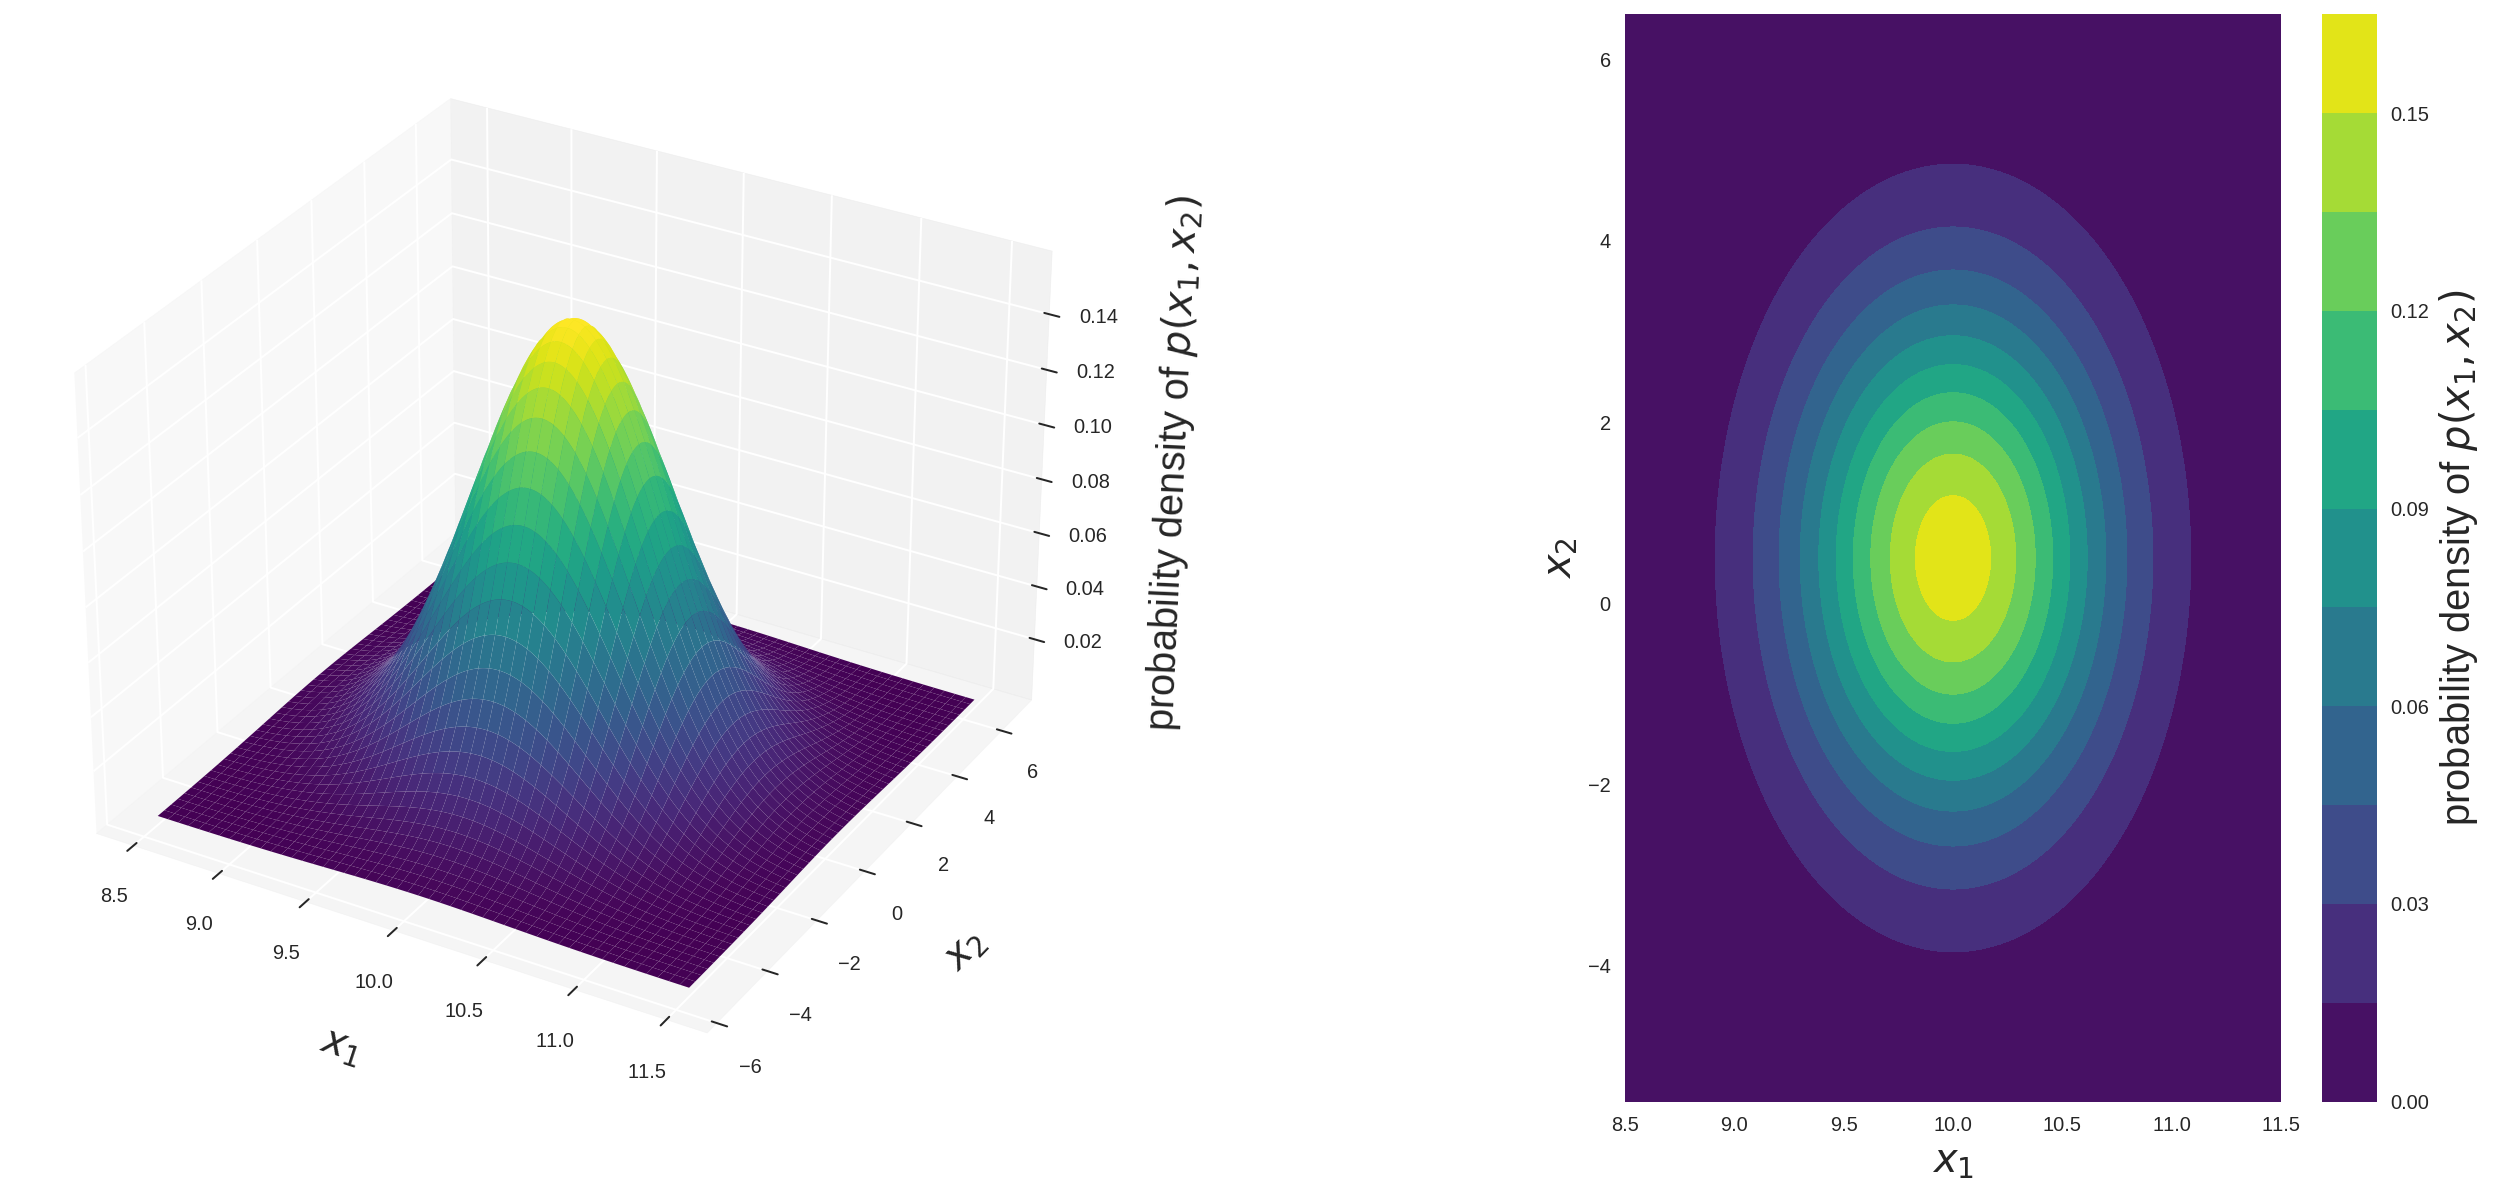

In [6]:
# Same pdf but now as a surface plot and as a contour plot.
fig_joint_pdf_ex1_color

## Car stopping distance problem (I know how much you missed it!)

Back to our simple car stopping distance problem with constant velocity $x=75$ m/s.

We have two rv's for this problem,

$$
\mathbf{x}=\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}= \begin{bmatrix}
y \\
z
\end{bmatrix}
$$

* Note: this $\mathbf{x}$ has NOTHING to do with our velocity variable $x$. Be careful!

$$
\begin{align}
\boldsymbol{\Sigma} = \text{Cov}[\mathbf{x}] &= \mathbb{E}\left[(y-\mathbb{E}[y])(z-\mathbb{E}[z])^T \right] \\
 &= \begin{bmatrix}
\mathbb{V}[y] & \text{Cov}[y,z] \\
\text{Cov}[z,y] & \mathbb{V}[z]
\end{bmatrix}
\end{align}
$$

where $\text{Cov}[y,z] = \mathbb{E}\left[(y-\mathbb{E}[y])(z-\mathbb{E}[z])\right] = \mathbb{E}[y z] - \mathbb{E}[y][z]$

### Exercise 2: Covariance matrix for the car problem when $x=75$ m/s

1. Calculate the mean vector and covariance matrix values for our problem (with $x=75$ m/s). **Be careful** that $y$ is dependent on $z$!

2. Calculate the determinant of the covariance matrix.

Once you are done, let's plot the multivariate Gaussian $p(y,z)$ obtained from the mean vector and covariance matrix you calculated.

This result for the determinant of $\text{Cov}[\mathbf{x}]\equiv\text{Cov}\left[\begin{matrix}y\\z\end{matrix}\right]$ arises from the fact that $y$ is **linearly** dependent on $z$.

Yet, be careful when interpreting covariance values and the covariance matrix!

* Independent implies uncorrelated: if two rv's $y$ and $z$ are **independent**, then $\text{Cov}[y,z]=0$

* **But** uncorrelated does not imply independent: two rv's can be **uncorrelated** ($\text{Cov}[y,z]=0$) but they may not be independent!


In [7]:
from scipy.stats import multivariate_normal # import from scipy.stats the multivariate Gaussian distribution

# Create a function that plots the MVN for the car stopping distance problem.
# Note, because the joint pdf p(y,z) includes the Dirac delta, including Tikhonov regularization
def plot_car_MVN_regularized(tikhonov_regularization):
    x = 75 # x is not an rv so its mean is equal to its value, i.e. E[x] = mu_x = x
    mu_z = 1.5; sigma_z = 0.5; # parameters of p(z)
    mu_y = x*mu_z+0.1*x**2; sigma_y = np.sqrt(sigma_z**2*x**2); # parameters of p(y)
    # Calculate elements of the Covariance matrix
    Variance_z = sigma_z**2
    Expected_z = mu_z
    Variance_y = sigma_z**2*x**2 # Variance of y (Exercise 2 of Lecture 2)
    Expected_y = mu_z*x+0.1*x**2 # E[y] = mu_y (Exercise 2 of Lecture 2), i.e. the mean of y (given z)
    Expected_yz = (sigma_z**2+mu_z**2)*x+0.1*x**2*mu_z # E[yz] 
    #
    Covariance_yz = Expected_yz - Expected_y*Expected_z # covariance between y and z
    #
    Covariance_matrix = [[Variance_y+tikhonov_regularization, Covariance_yz],
                         [Covariance_yz                     , Variance_z+tikhonov_regularization]]
    #
    mean_vector = [Expected_y, Expected_z]
    #
    MVN_rvs = multivariate_normal(mean_vector, Covariance_matrix) # this is p(y,z)
    #
    N_samples = 1000 # number of samples
    #
    # Create grid of points for plotting the MVN pdf
    y_grid, z_grid = np.mgrid[-3*sigma_y+mu_y:3*sigma_y+mu_y:6*sigma_y/N_samples, # Define range of y_grid
                              -3*sigma_z+mu_z:3*sigma_z+mu_z:6*sigma_z/N_samples] # Define z_grid
    #
    pos = np.dstack((y_grid, z_grid)) # put all the grid points into a single matrix for convenience
    MVN_pdf_grid = MVN_rvs.pdf(pos) # calculate p(y,z) for each grid point
    #
    #Make a 3D plot
    fig_MVN = plt.figure()
    gs = GridSpec(1, 3) # to handle subplot placement easier
    # Subplot with a 3D surface of the joint pdf p(y,z):
    ax_MVN_surface = fig_MVN.add_subplot(gs[0,:2], projection='3d') # use 1x2 grid to make 3D plot bigger
    ax_MVN_surface.set_facecolor('white') # set background for this subplot
    ax_MVN_surface.plot_surface(z_grid, y_grid, MVN_pdf_grid,cmap='viridis',linewidth=0)
    ax_MVN_surface.set_xlabel('z', fontsize=20)
    ax_MVN_surface.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
    ax_MVN_surface.set_ylabel('y', fontsize=20)
    ax_MVN_surface.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
    ax_MVN_surface.set_zlabel('probability density of p(y, z)', fontsize=20)
    ax_MVN_surface.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
    ax_MVN_surface.set_title('Multivariate Normal distribution (MVN)', fontsize=20)
    # Subplot with the contour of the joint pdf p(y,z)
    ax_MVN_contour = fig_MVN.add_subplot(gs[0,2])
    CS = ax_MVN_contour.contourf(z_grid, y_grid, MVN_pdf_grid, 10, cmap="viridis")
    ax_MVN_contour.set_xlabel('z', fontsize=20)
    ax_MVN_contour.set_ylabel('y', fontsize=20)
    cbar = fig_MVN.colorbar(CS) # Make a colorbar for the ContourSet returned by the contourf call.
    cbar.ax.set_ylabel('probability density of p(y, z)', fontsize=20)
    ax_MVN_contour.set_title('Multivariate Normal distribution (MVN)', fontsize=20)
    #
    # Create figure with specified size
    fig_MVN.set_size_inches(25, 10)

/tmp/ipykernel_11545/1352065197.py:53: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig_MVN.colorbar(CS) # Make a colorbar for the ContourSet returned by the contourf call.


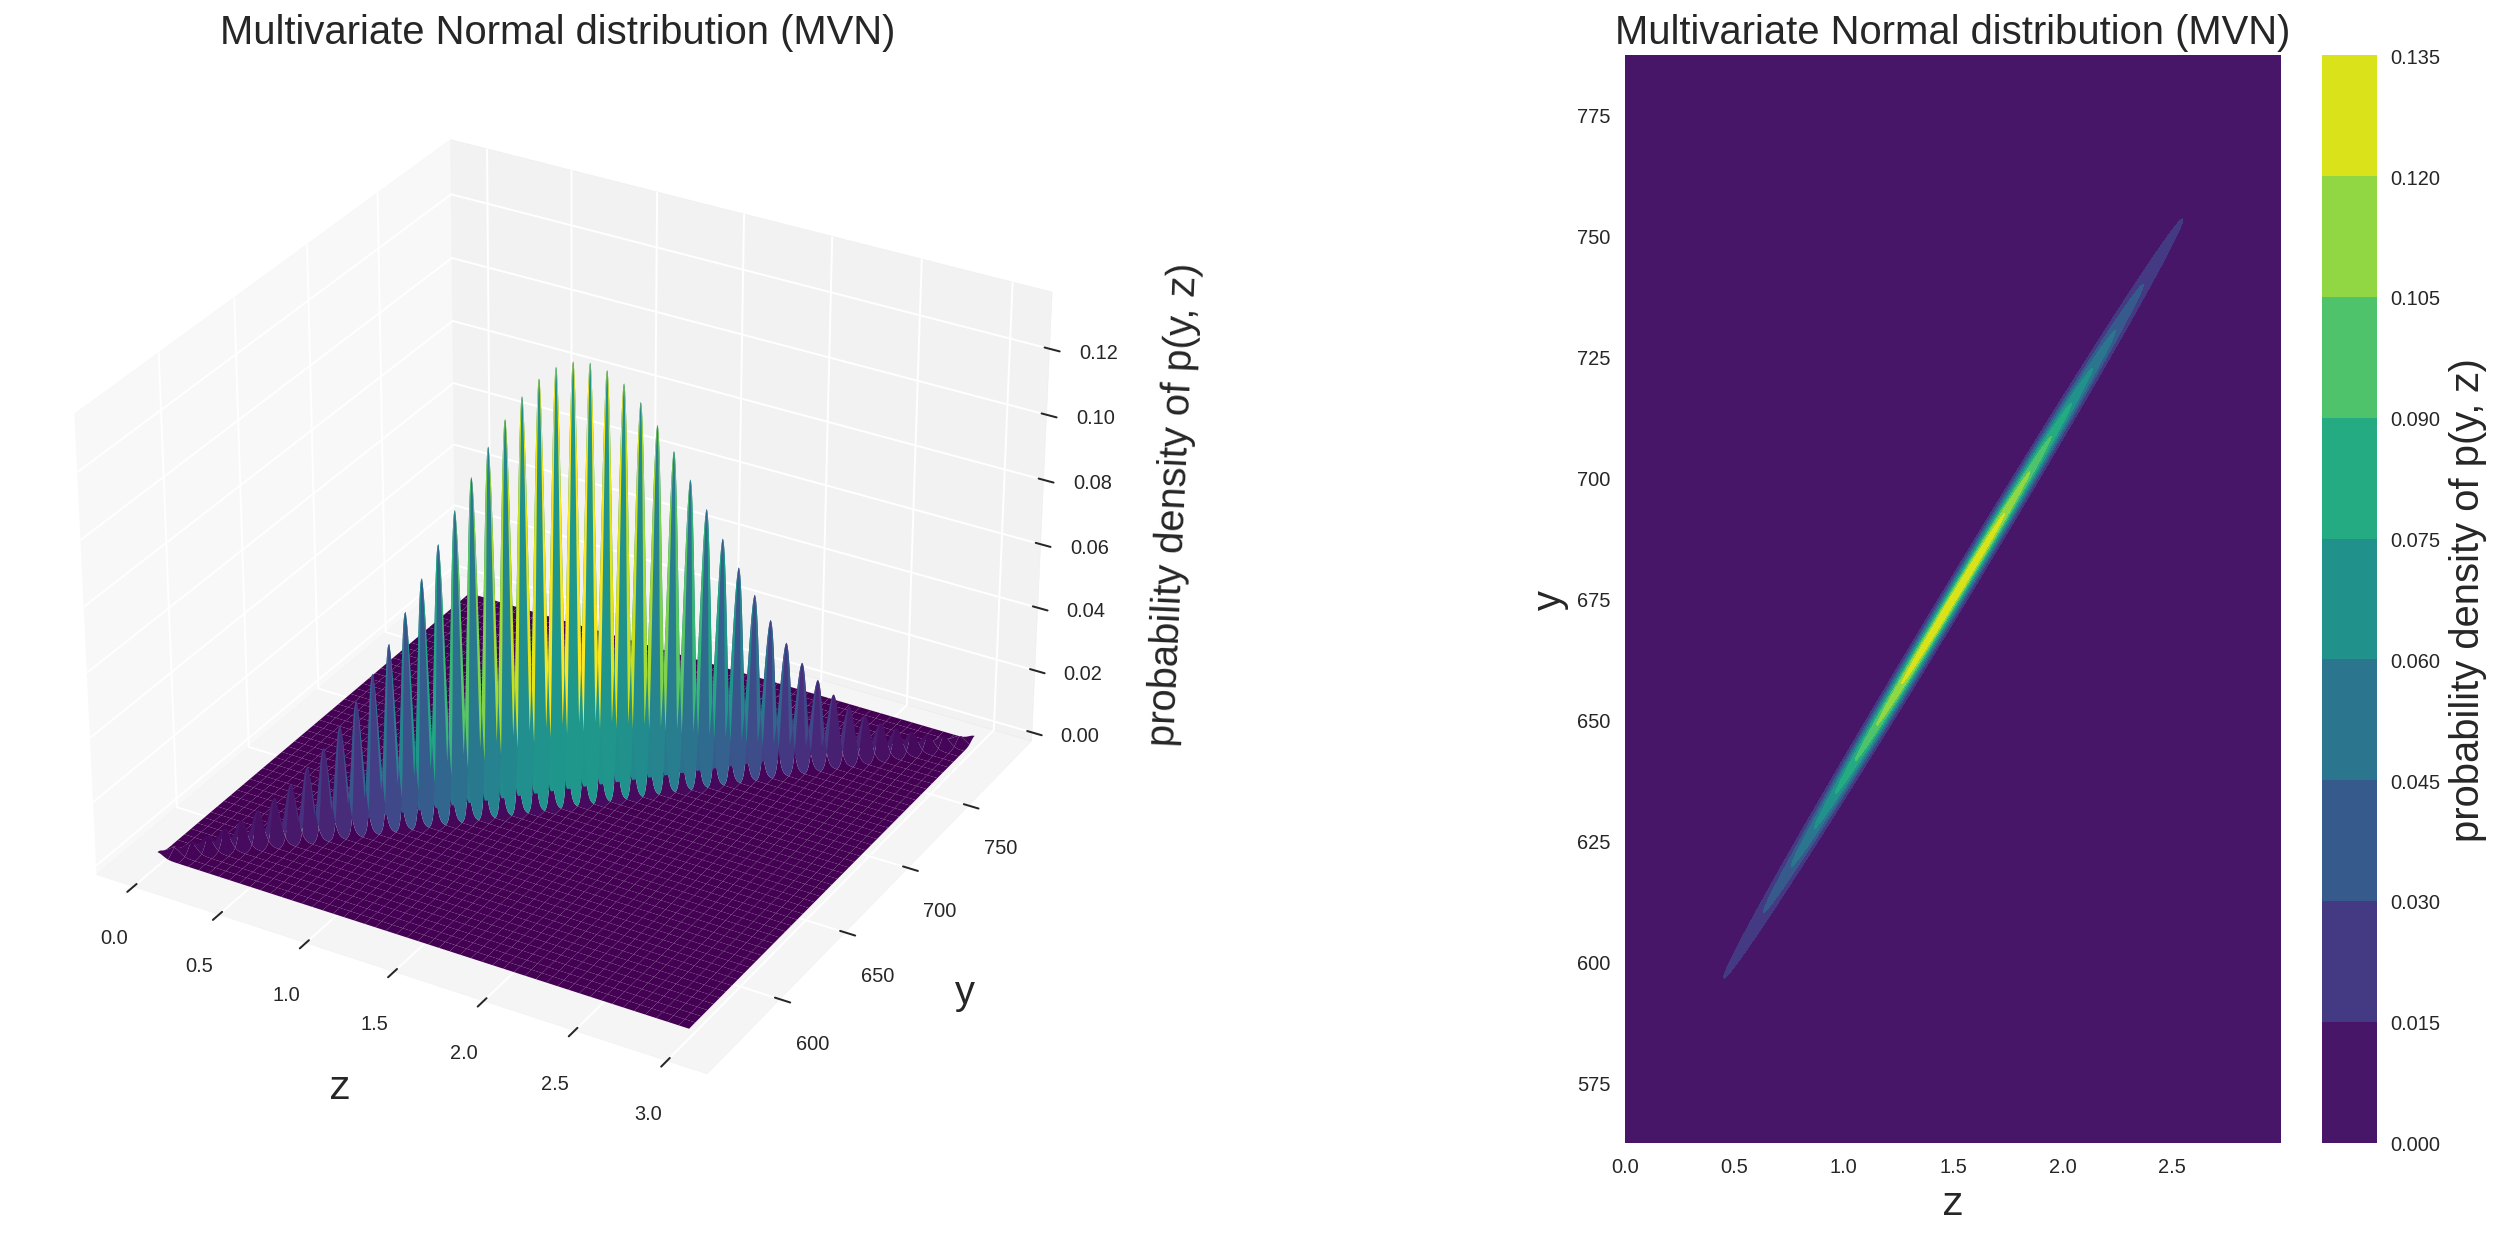

In [8]:
# Code to generate this figure is hidden in presentation (shown in notes)
regularizer = 1e-3 # Thikhonov regularization to approximate p(y,z) for car stopping distance problem
plot_car_MVN_regularized(regularizer) # SHOW WHAT HAPPENS IF regularizer is 0, 0.1 and 1e-3

### Recal the joint pdf $p(y,z)$ we found for this problem in Lecture 3!

We determined in Lecture 3 that the joint pdf $p(y,z)$ for this problem is

$$
p(y, z) = \delta\left(y-(z x+0.1x^2)\right) p(z)
$$

where $p(z) = \mathcal{N}(\mu_z=1.5,\sigma_z^2=0.5^2)$, and $p(y|z)=\delta\left(y-(z x+0.1x^2)\right)$ is the Dirac delta pdf that assigns zero probability everywhere except when $y=z x+0.1x^2$.

* Now we see how to approximate this pdf for plotting it:
    * We can consider that the joint pdf $p(y,z)$ is an MVN, and include a small term in the diagonal of the Covariance matrix to plot it! As this term tends to zero, we retrieve the Dirac delta effect.

### A slightly more complicated car stopping distance problem

<img src="docs/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

Let's focus (again) on our favorite problem, but this time we include two rv's $z_1$ and $z_2$ in the governing model:

$\require{color}{\color{red}y} = {\color{blue}z_1}\cdot x + {\color{magenta}z_2}\cdot x^2$

- ${\color{red}y}$ is the **output**: the car stopping distance (in meters)
- ${\color{blue}z_1}$ is a hidden variable: an <a title="random variable">rv</a> representing the driver's reaction time (in seconds)
- ${\color{magenta}z_2}$ is another hidden variable: an <a title="random variable">rv</a> that depends on the coefficient of friction, the inclination of the road, the weather, etc. (in m$^{-1}$s$^{-2}$).
- $x$ is the **input**: constant car velocity (in m/s).

where we will assume as before that $z_1 \sim \mathcal{N}(\mu_{z_1}=1.5,\sigma_{z_1}^2=0.5^2)$, but now we assume $z_2 \sim \mathcal{N}(\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$. Recall that in previous lectures we assumed $z_2=0.1$.

## A slightly more complicated car stopping distance problem

<img src="docs/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">

For simplicity, also consider that every driver is going at the same velocity $x=75$ m/s.

$\require{color}{\color{red}y} = {\color{blue}z_1}\cdot 75 + {\color{magenta}z_2}\cdot 75^2 = 75 {\color{blue}z_1} + 5625 {\color{magenta}z_2}$

where $z_1 \sim \mathcal{N}(\mu_{z_1}=1.5,\sigma_{z_1}^2=0.5^2)$, and $z_2 \sim \mathcal{N}(\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$.

# <font color='red'>HOMEWORK</font>

For the slightly more complicated car stopping distance problem, answer this:

1. Show that the conditional pdf $p(y|z_1)$ is:

$$
p(y|z_1) = \mathcal{N}\left(y | \mu_{y|z_1}=5625\mu_{z_2}+75z_1, \sigma_{y|z_1}^2=(5625\sigma_{z_2})^2\right)
$$

2. What is the joint pdf $p(y,z_1)$?

3. Calculate the covariance matrix for $\mathbf{x}=\begin{bmatrix}y\\z_1\end{bmatrix}$, i.e. $\text{Cov}\left(\begin{bmatrix}y\\z_1\end{bmatrix}\right)$
    
The next cell includes the plots of $p(y|z_1)$, $p(y,z_1)$. **But do your HOMEWORK!**

In [9]:
# preliminary information (think about this as information hidden inside the model):
x = 75; # constant velocity
mu_z2 = 0.1; sigma_z2 = 0.01; # parameters of p(z2)

# Parameters for p(z1):
mu_z1 = 1.5; sigma_z1 = 0.5;

# Parameters for p(y) (calculated):
mu_y = x*mu_z1+x**2*mu_z2 # If you determined p(y,z1) first, you can also calculate this from the
                          # law of iterated expectations (Section 2.2.5.4)
sigma_y = np.sqrt((x*sigma_z1)**2+(x*sigma_z2)**2) # If you determined p(y,z1) first, you can
                                                   # also calculate this from the law of total
                                                   # variance (Section 2.2.5.4)

#------------------------------------------------------------------------------------------
# It's instructive to calculate p(z1), p(y|z1) and p(y,z1) by defining functions (although it is slower...)

# Calculate a sample from p(z1), i.e. z1 ~ N(mu_z1, sigma_z1):
def pdf_z1(z1_value,mu_z1, sigma_z1):
    pdf_z1 = norm.pdf(z1_value, mu_z1, sigma_z1) # p(z1_value)
    return pdf_z1

# Parameters for p(y|z1):
def pdf_yGIVENz1(y_value,z1_value, x,mu_z2,sigma_z2):
    mu_yGIVENz1 = x**2*mu_z2+75*z1_value # mean of p(y|z1); note that it depends on the value of z1
    sigma_yGIVENz1 = x**2*sigma_z2; # std of p(y|z1); note that it does not depend on the value of z1
    # NOTE two things about p(y|z1):
    #      1. this pdf is both a function of y and of the given values of z1
    #      2. this pdf has a constant variance, but that is not the case for its mean!
    pdf_yGIVENz1 = norm.pdf(y_value, mu_yGIVENz1, sigma_yGIVENz1) # p(y_value|z1_value)
    return pdf_yGIVENz1

# Parameters for joint pdf p(y,z1):
def pdf_joint_y_z1(y_value,z1_value, x,mu_z2,sigma_z2,mu_z1,sigma_z1):
    # compute p(y_value,z1_value) by calling the respective functions:
    pdf_joint_y_z1 = pdf_yGIVENz1(y_value,z1_value, x,mu_z2,sigma_z2)*pdf_z1(z1_value,mu_z1, sigma_z1)
    # just one sample from p(y,z1)
    return pdf_joint_y_z1

# Take a sample from z1 ~ p(z1) and y ~ p(y|z1):
def sample_joint_y_z1(mu_z1,sigma_z1,mu_z2,sigma_z2,x):
    sample_z1 = norm.rvs(mu_z1, sigma_z1, size=1) # just one sample from p(z1)
    mu_yGIVENz1 = x**2*mu_z2+75*sample_z1 # mean of p(y|z1); note that it depends on the value of z1
    sigma_yGIVENz1 = x**2*sigma_z2; # std of p(y|z1); note that it does not depend on the value of z1
    sample_yGIVENz1 = norm.rvs(mu_yGIVENz1, sigma_yGIVENz1, size=1) # just one sample from p(y|z1)
    return sample_yGIVENz1, sample_z1
#------------------------------------------------------------------------------------------

N_samples = 300 # number of samples to create histograms and plots
# Create grid of points for plotting the p(y,z1):
z1_grid_min = -3*sigma_z1+mu_z1 # minimum value of z1 in plot
z1_grid_max = 3*sigma_z1+mu_z1 # maximum value of z1 in plot

#y_grid_min = -3*sigma_y+mu_y # minimum value of y in plot
#y_grid_max =  3*sigma_y+mu_y # maximum value of y in plot

y_grid_min = -3*(x**2*sigma_z2)+(x**2*mu_z2+75*z1_grid_min) # minimum value of y in plot
y_grid_max =  3*(x**2*sigma_z2)+(x**2*mu_z2+75*z1_grid_max) # maximum value of y in plot


y_grid, z1_grid = np.mgrid[y_grid_min:y_grid_max:(6*x**2*sigma_z2+75*6*sigma_z1)/N_samples, # Define range of y_grid
                           z1_grid_min:z1_grid_max:6*sigma_z1/N_samples] # Define z_grid
#
pos = np.dstack((y_grid, z1_grid)) # put all the grid points into a single matrix for convenience
joint_pdf_y_z1_grid = np.zeros_like(y_grid)
for idx_i, pos_i in enumerate(pos):
    for idx_j, pos_j in enumerate(pos_i):
        z1_value = pos_j[1] # z1 value for this grid point
        y_value = pos_j[0] # z1 value for this grid point
        joint_pdf_y_z1_grid[idx_i,idx_j] = pdf_joint_y_z1(y_value,z1_value, x,mu_z2,sigma_z2,mu_z1,sigma_z1)

#print(joint_pdf_y_z1_grid)
samples_yGIVENz1 = np.zeros(N_samples); samples_z1 = np.zeros(N_samples);
# Create N_samples of z1 and y:
for i_sample in range(N_samples):
    samples_yGIVENz1[i_sample], samples_z1[i_sample] = sample_joint_y_z1(mu_z1,sigma_z1,mu_z2,sigma_z2,x)

# This figure is created such that the histograms seem a projection of the 3D plot
# I used a simple trick of creating a grid of 3x3 subplots and assigning a 2x2 grid to the 3D plot alone
fig_joint_pdf_HW = plt.figure()
gs = GridSpec(3, 3) # to handle subplot placement easier

# Subplot with a 3D surface of the joint pdf p(y,z):
ax_joint_pdf_HW = fig_joint_pdf_HW.add_subplot(gs[1:,1:], projection='3d')
ax_joint_pdf_HW.set_facecolor('white') # set background for this subplot
ax_joint_pdf_HW.plot_wireframe(z1_grid, y_grid, joint_pdf_y_z1_grid, color = 'grey', alpha=0.5)
# samples in the z1-y plane:
ax_joint_pdf_HW.scatter(samples_z1,samples_yGIVENz1,np.zeros(N_samples), alpha = .7, s = 10)
# show the mean in z1-y plane:
ax_joint_pdf_HW.scatter(np.mean(samples_z1), np.mean(samples_yGIVENz1), marker = "x", c = "r", s=50)
ax_joint_pdf_HW.set_xlabel(r"$z_1$", fontsize=20)
ax_joint_pdf_HW.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_ylabel(r"$y$", fontsize=20)
ax_joint_pdf_HW.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_zlabel(r"$p(y,z_1)$", fontsize=20)
ax_joint_pdf_HW.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_xlim3d(z1_grid_min,z1_grid_max) # z1 axis limits
ax_joint_pdf_HW.set_ylim3d(y_grid_min,y_grid_max) # y axis limits
#ax_joint_pdf.set_title("Joint probability: $p(y,z1)$ [for fixed x=75]", fontsize=20)

# Remind the histogram and pdf for the marginal pdf p(z_1):
z1range = np.linspace(z1_grid_min,z1_grid_max,N_samples) # z1 range for plotting p(z1)
ax_hist_z1_HW = fig_joint_pdf_HW.add_subplot(gs[0,2])
ax_hist_z1_HW.hist(samples_z1, bins='auto', density=True, label='Histogram $p(z_1)$')  
ax_hist_z1_HW.plot(z1range, norm.pdf(z1range, mu_z1, sigma_z1), 'k--', linewidth = 3, label='$p(z_1)$')
ax_hist_z1_HW.set_xlabel("$z_1$", fontsize=20)
ax_hist_z1_HW.set_ylabel("probability density", fontsize=20)
ax_hist_z1_HW.legend(fontsize=15, loc='upper left');

# Finally, it's also nice to show the marginal pdf p(y):
yrange = np.linspace(-3*sigma_y+mu_y,3*sigma_y+mu_y,N_samples) # y range for plotting p(y)
samples_y = norm.rvs(mu_y, sigma_y, size=N_samples) # samples from p(y) for histogram
ax_hist_y_HW = fig_joint_pdf_HW.add_subplot(gs[1,0]) # place it in position [1,0] in the 3x3 grid
ax_hist_y_HW.hist(samples_y, bins='auto', density=True, label='Histogram $p(y)$')  
ax_hist_y_HW.plot(yrange, norm.pdf(yrange, mu_y, sigma_y),
                 'k--', linewidth = 3, label='$p(y)$')
ax_hist_y_HW.set_xlabel("$y$", fontsize=20)
ax_hist_y_HW.set_ylabel("probability density", fontsize=20)
ax_hist_y_HW.legend(fontsize=15, loc='upper left');

# Create figure with specified size but close it so that we open the figure just for presentation
fig_joint_pdf_HW.set_size_inches(25, 15) # scale figure to be wider (since there are 2 subplots)
plt.close(fig_joint_pdf_HW) # do not plot the figure now. We will show it in a later cell

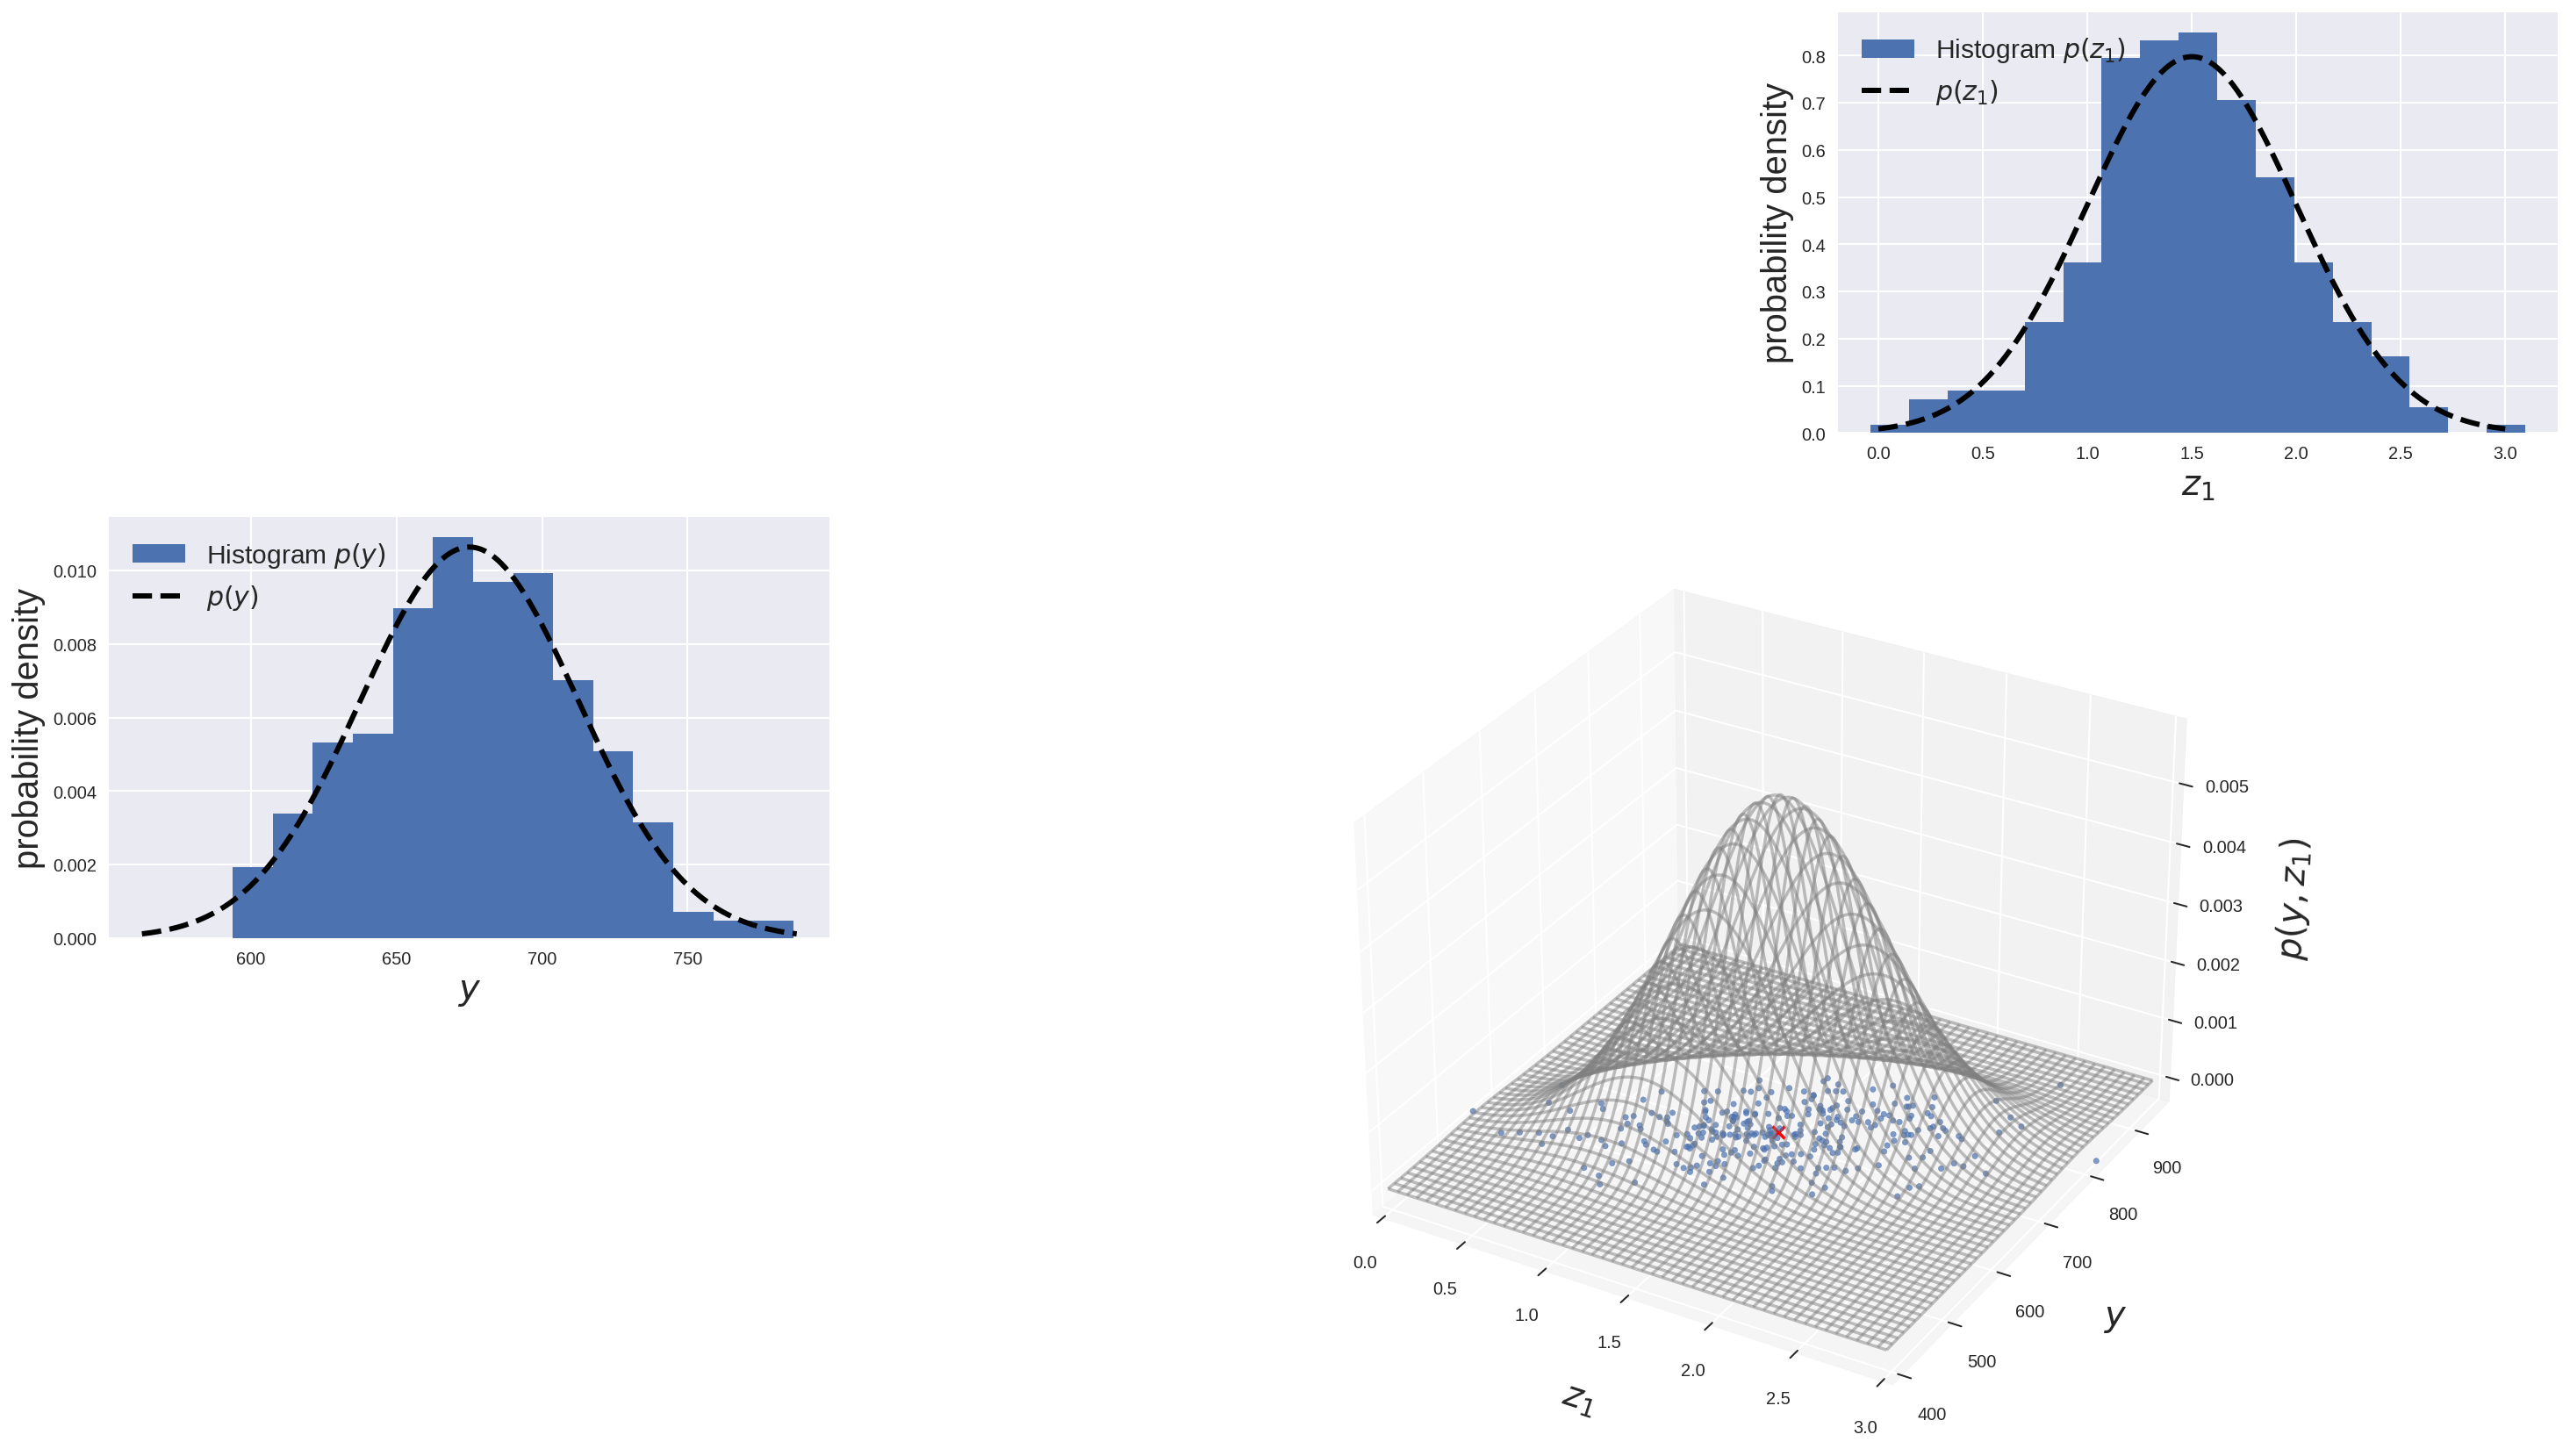

In [10]:
# HIGHLIGHT DIFFERENCE IN MAXIMUM PROBABILITY DENSITIES!!
fig_joint_pdf_HW # The joint pdf results from the multiplication...

In [11]:
#Make a 3D plot
fig_joint_pdf_HW_color = plt.figure()
gs = GridSpec(1, 3) # to handle subplot placement easier

# Subplot with a 3D surface of the joint pdf p(y,z):
ax_joint_pdf_HW_color_surface = fig_joint_pdf_HW_color.add_subplot(gs[0,:2], projection='3d') # use 1x2 grid to make 3D plot bigger
ax_joint_pdf_HW_color_surface.set_facecolor('white') # set background for this subplot
ax_joint_pdf_HW_color_surface.plot_surface(z1_grid, y_grid, joint_pdf_y_z1_grid,cmap='viridis',linewidth=0)
ax_joint_pdf_HW_color_surface.set_xlabel('$z_1$', fontsize=20)
ax_joint_pdf_HW_color_surface.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW_color_surface.set_ylabel('$y$', fontsize=20)
ax_joint_pdf_HW_color_surface.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW_color_surface.set_zlabel('probability density of $p(y, z_1)$', fontsize=20)
ax_joint_pdf_HW_color_surface.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
#ax_joint_pdf_HW_color_surface.set_title('Multivariate Normal distribution (MVN)', fontsize=20)

# Subplot with the contour of the joint pdf p(y,z)
ax_joint_pdf_HW_color_contour2 = fig_joint_pdf_HW_color.add_subplot(gs[0,2])
CS = ax_joint_pdf_HW_color_contour2.contourf(z1_grid, y_grid, joint_pdf_y_z1_grid, 10, cmap="viridis")
ax_joint_pdf_HW_color_contour2.set_xlabel('$z_1$', fontsize=20)
ax_joint_pdf_HW_color_contour2.set_ylabel('$y$', fontsize=20)
cbar = fig_joint_pdf_HW_color.colorbar(CS) # Make a colorbar for the ContourSet returned by the contourf call.
cbar.ax.set_ylabel('probability density of $p(y, z_1)$', fontsize=20)
#ax_MVN_contour2.set_title('Multivariate Normal distribution (MVN)', fontsize=20)

# Create figure with specified size
fig_joint_pdf_HW_color.set_size_inches(25, 10)
plt.close(fig_joint_pdf_HW_color) # do not plot the figure now. We will show it in a later cell

/tmp/ipykernel_11545/4050122741.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig_joint_pdf_HW_color.colorbar(CS) # Make a colorbar for the ContourSet returned by the contourf call.


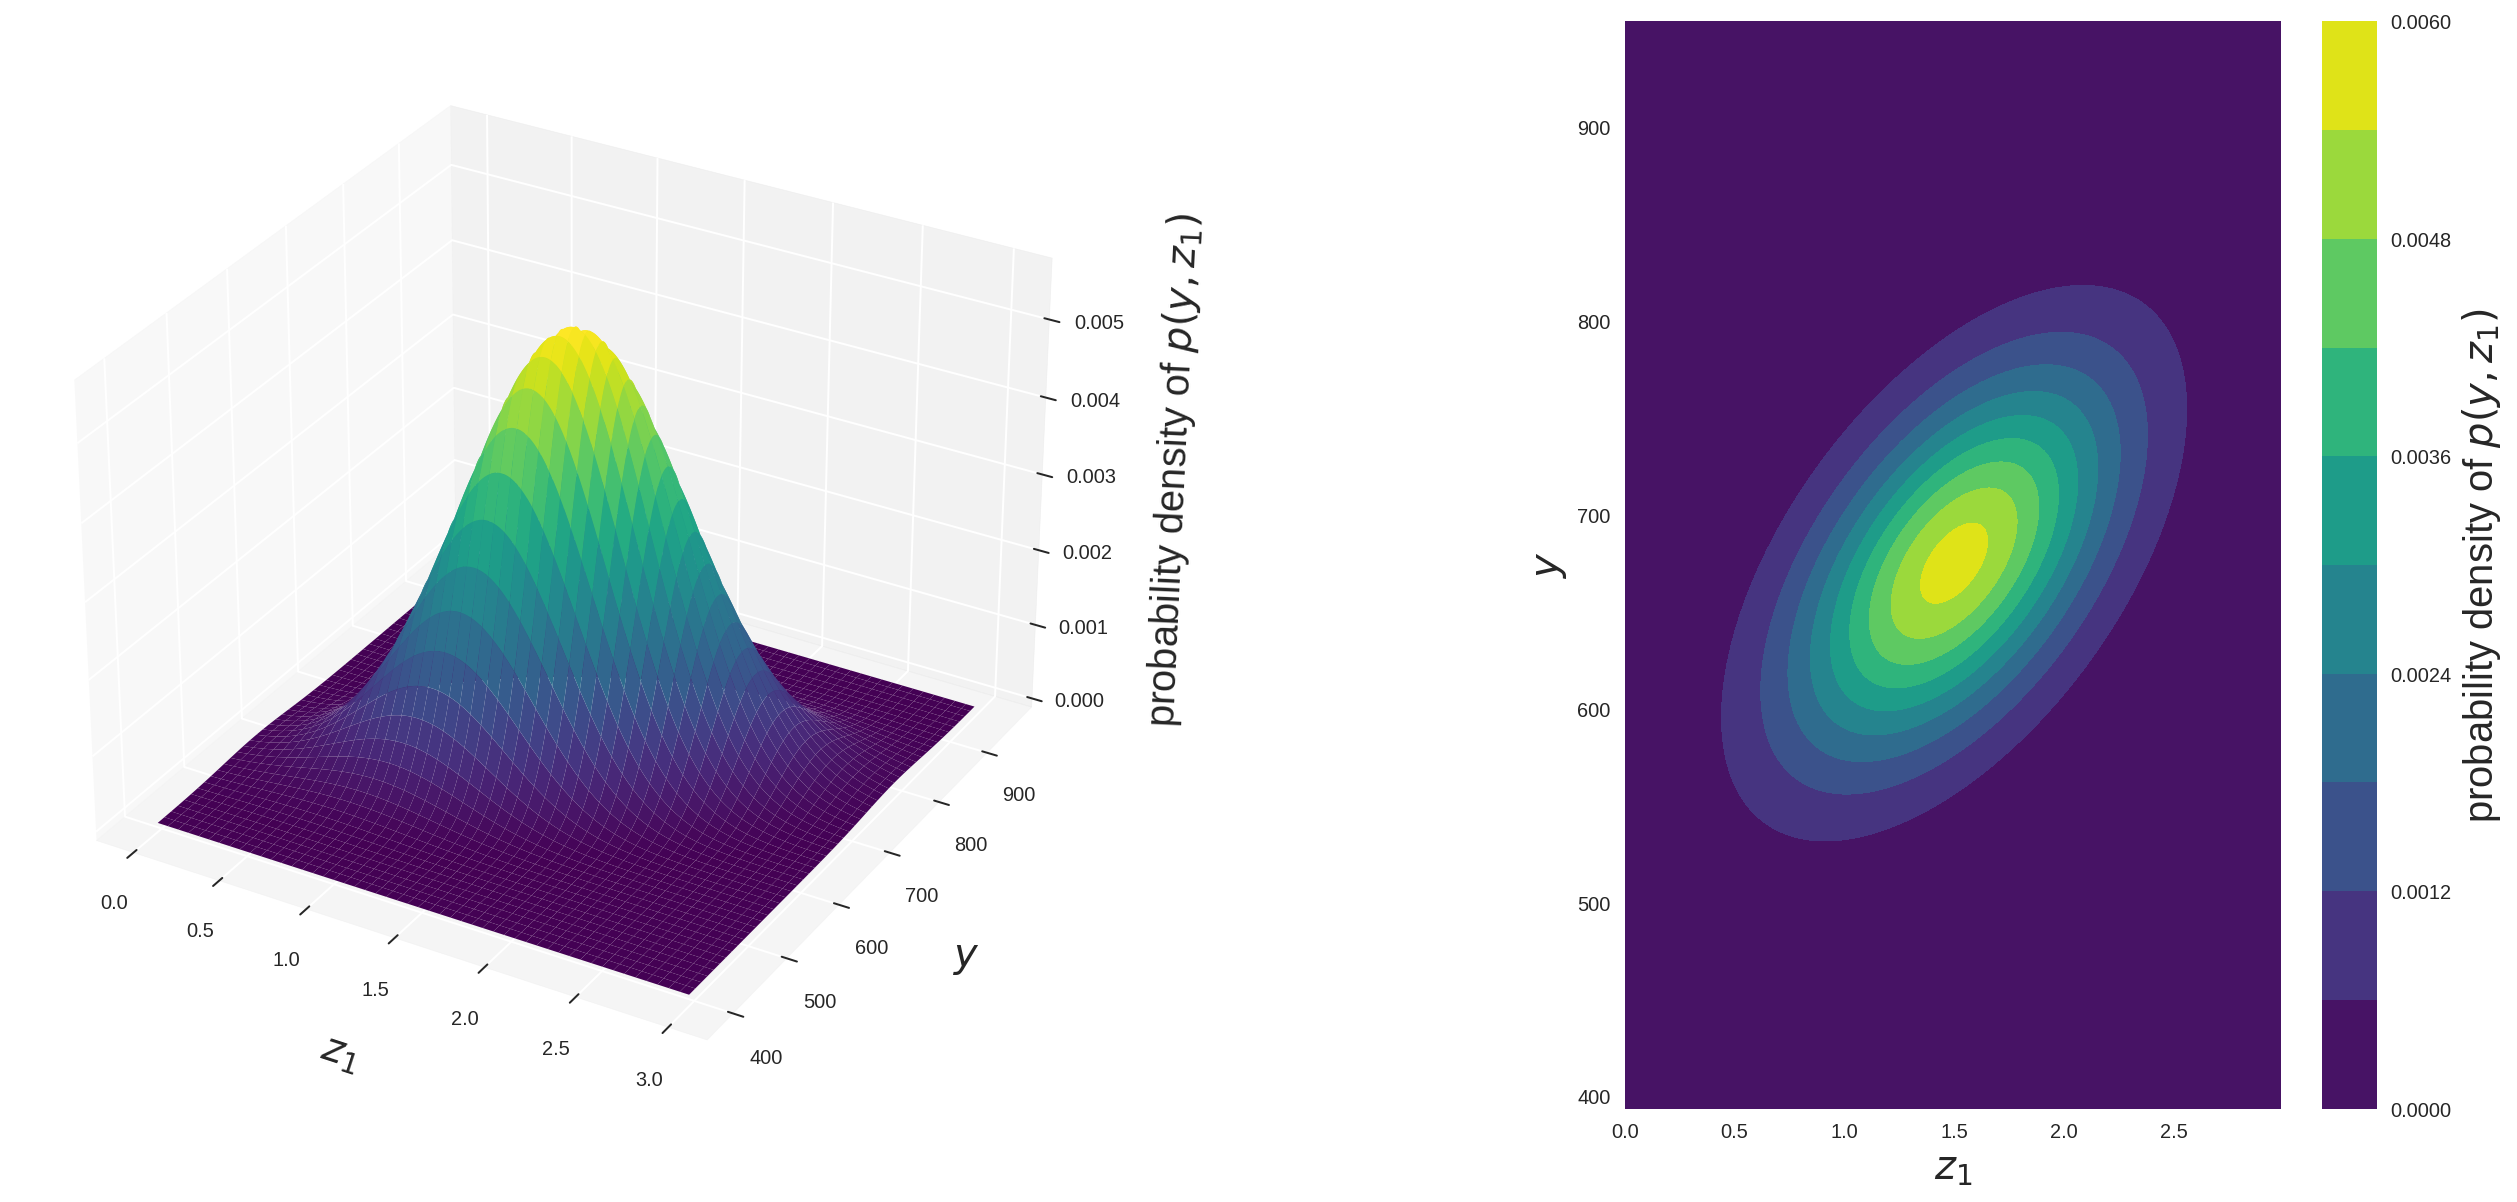

In [12]:
# Same pdf but now as a surface plot and as a contour plot.
fig_joint_pdf_HW_color

NameError: name 'z2range' is not defined

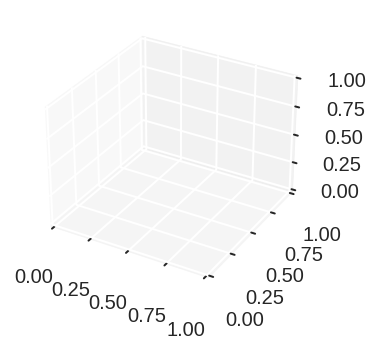

In [13]:
# preliminary information (think about this as information hidden inside the model):
x = 75; # constant velocity
mu_z2 = 0.25; sigma_z2 = 0.07; # parameters of p(z2)

# Parameters for p(z1):
mu_z1 = 1.5; sigma_z1 = 0.5;

# Parameters for p(y) (calculated):
mu_y = x*mu_z1+x**2*mu_z2 # If you determined p(y,z1) first, you can also calculate this from the
                          # law of iterated expectations (Section 2.2.5.4)
sigma_y = np.sqrt((x*sigma_z1)**2+(x*sigma_z2)**2) # If you determined p(y,z1) first, you can
                                                   # also calculate this from the law of total
                                                   # variance (Section 2.2.5.4)


        
        
N_samples = 300 # number of samples to create histograms and plots
# Create grid of points for plotting the p(y,z1):
z1_grid_min = -3*sigma_z1+mu_z1 # minimum value of z1 in plot
z1_grid_max = 3*sigma_z1+mu_z1 # maximum value of z1 in plot

#y_grid_min = -3*sigma_y+mu_y # minimum value of y in plot
#y_grid_max =  3*sigma_y+mu_y # maximum value of y in plot

y_grid_min = -3*(x**2*sigma_z2)+(x**2*mu_z2+75*z1_grid_min) # minimum value of y in plot
y_grid_max =  3*(x**2*sigma_z2)+(x**2*mu_z2+75*z1_grid_max) # maximum value of y in plot


y_grid, z1_grid = np.mgrid[y_grid_min:y_grid_max:(6*x**2*sigma_z2+75*6*sigma_z1)/N_samples, # Define range of y_grid
                           z1_grid_min:z1_grid_max:6*sigma_z1/N_samples] # Define z_grid
#
pos = np.dstack((y_grid, z1_grid)) # put all the grid points into a single matrix for convenience
joint_pdf_y_z1_grid = np.zeros_like(y_grid)
for idx_i, pos_i in enumerate(pos):
    for idx_j, pos_j in enumerate(pos_i):
        z1_value = pos_j[1] # z1 value for this grid point
        y_value = pos_j[0] # z1 value for this grid point
        joint_pdf_y_z1_grid[idx_i,idx_j] = pdf_joint_y_z1(y_value,z1_value, x,mu_z2,sigma_z2,mu_z1,sigma_z1)

#print(joint_pdf_y_z1_grid)
samples_yGIVENz1 = np.zeros(N_samples); samples_z1 = np.zeros(N_samples);
# Create N_samples of z1 and y:
for i_sample in range(N_samples):
    samples_yGIVENz1[i_sample], samples_z1[i_sample] = sample_joint_y_z1(mu_z1,sigma_z1,mu_z2,sigma_z2,x)

# This figure is created such that the histograms seem a projection of the 3D plot
# I used a simple trick of creating a grid of 3x3 subplots and assigning a 2x2 grid to the 3D plot alone
fig_joint_pdf_HW = plt.figure()
gs = GridSpec(3, 3) # to handle subplot placement easier






# Subplot with a 3D surface of the joint pdf p(y,z):
ax_joint_pdf_HW = fig_joint_pdf_HW.add_subplot(gs[1:,1:], projection='3d')
ax_joint_pdf_HW.set_facecolor('white') # set background for this subplot
z1_grid,z2_grid = np.meshgrid(z1range,z2range) # grid for surface plot
joint_pdf_grid_HW = x*norm.pdf(z1_grid,mu_x1,sigma_x1)+x**2*norm.pdf(z2_grid,mu_z2,sigma_z2) # joint pdf values
ax_joint_pdf_ex1.plot_wireframe(x1_grid, x2_grid, joint_pdf_grid_ex1, color = 'grey', alpha=0.5) # surface plot
ax_joint_pdf_HW.set_xlabel(r"$z_1$", fontsize=20)
ax_joint_pdf_HW.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_ylabel(r"$y$", fontsize=20)
ax_joint_pdf_HW.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_zlabel(r"$p(y,z_1)$", fontsize=20)
ax_joint_pdf_HW.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_xlim3d(z1_grid_min,z1_grid_max) # z1 axis limits
ax_joint_pdf_HW.set_ylim3d(y_grid_min,y_grid_max) # y axis limits
#ax_joint_pdf.set_title("Joint probability: $p(y,z1)$ [for fixed x=75]", fontsize=20)






# Subplot with a 3D surface of the joint pdf p(y,z):
ax_joint_pdf_HW = fig_joint_pdf_HW.add_subplot(gs[1:,1:], projection='3d')
ax_joint_pdf_HW.set_facecolor('white') # set background for this subplot
ax_joint_pdf_HW.plot_wireframe(z1_grid, y_grid, joint_pdf_y_z1_grid, color = 'grey', alpha=0.5)
# samples in the z1-y plane:
ax_joint_pdf_HW.scatter(samples_z1,samples_yGIVENz1,np.zeros(N_samples), alpha = .7, s = 10)
# show the mean in z1-y plane:
ax_joint_pdf_HW.scatter(np.mean(samples_z1), np.mean(samples_yGIVENz1), marker = "x", c = "r", s=50)
ax_joint_pdf_HW.set_xlabel(r"$z_1$", fontsize=20)
ax_joint_pdf_HW.xaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_ylabel(r"$y$", fontsize=20)
ax_joint_pdf_HW.yaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_zlabel(r"$p(y,z_1)$", fontsize=20)
ax_joint_pdf_HW.zaxis.labelpad=20 # offset label from numbers (to avoid overlap)
ax_joint_pdf_HW.set_xlim3d(z1_grid_min,z1_grid_max) # z1 axis limits
ax_joint_pdf_HW.set_ylim3d(y_grid_min,y_grid_max) # y axis limits
#ax_joint_pdf.set_title("Joint probability: $p(y,z1)$ [for fixed x=75]", fontsize=20)

# Remind the histogram and pdf for the marginal pdf p(z_1):
z1range = np.linspace(z1_grid_min,z1_grid_max,N_samples) # z1 range for plotting p(z1)
ax_hist_z1_HW = fig_joint_pdf_HW.add_subplot(gs[0,2])
ax_hist_z1_HW.hist(samples_z1, bins='auto', density=True, label='Histogram $p(z_1)$')  
ax_hist_z1_HW.plot(z1range, norm.pdf(z1range, mu_z1, sigma_z1), 'k--', linewidth = 3, label='$p(z_1)$')
ax_hist_z1_HW.set_xlabel("$z_1$", fontsize=20)
ax_hist_z1_HW.set_ylabel("probability density", fontsize=20)
ax_hist_z1_HW.legend(fontsize=15, loc='upper left');

# Finally, it's also nice to show the marginal pdf p(y):
yrange = np.linspace(-3*sigma_y+mu_y,3*sigma_y+mu_y,N_samples) # y range for plotting p(y)
samples_y = norm.rvs(mu_y, sigma_y, size=N_samples) # samples from p(y) for histogram
ax_hist_y_HW = fig_joint_pdf_HW.add_subplot(gs[1,0]) # place it in position [1,0] in the 3x3 grid
ax_hist_y_HW.hist(samples_y, bins='auto', density=True, label='Histogram $p(y)$')  
ax_hist_y_HW.plot(yrange, norm.pdf(yrange, mu_y, sigma_y),
                 'k--', linewidth = 3, label='$p(y)$')
ax_hist_y_HW.set_xlabel("$y$", fontsize=20)
ax_hist_y_HW.set_ylabel("probability density", fontsize=20)
ax_hist_y_HW.legend(fontsize=15, loc='upper left');

# Create figure with specified size but close it so that we open the figure just for presentation
fig_joint_pdf_HW.set_size_inches(25, 15) # scale figure to be wider (since there are 2 subplots)
plt.close(fig_joint_pdf_HW) # do not plot the figure now. We will show it in a later cell

## Conclusions about Gaussian distributions

Our empirical investigations in this Lecture, have led to some interesting observations! They can be generalized to:
* If two sets of variables are jointly Gaussian, i.e. if their joint pdf is an MVN, then:
    * their conditional pdfs are Gaussian, i.e. the conditional distribution of one set conditioned on the other is again Gaussian!
    * the marginal distribution of either set is also Gaussian!

<font color='blue'>This is really important because it means that Gaussians are closed under Bayesian conditioning!</font> We will explore this later.

* Note: Bishop's book has a fantastic discussion about the univariate and multivariate Gaussian distribution (Section 2.3). **I recommend reading it.** I included it in the notes below this cell.

## Summary of partitioned Gaussians

Given a joint Gaussian pdf $p(\mathbf{x})=\mathcal{N}(\mathbf{x}|\boldsymbol{\mu},\boldsymbol{\Sigma})$ with $\boldsymbol{\Lambda}\equiv\boldsymbol{\Sigma}^{-1}$ and

$$
\mathbf{x}=\begin{bmatrix}
\mathbf{x}_a \\
\mathbf{x}_b
\end{bmatrix}, \quad \boldsymbol{\mu} = \begin{bmatrix}
\boldsymbol{\mu}_a \\
\boldsymbol{\mu}_b
\end{bmatrix}, \quad
\boldsymbol{\Sigma} = \begin{bmatrix}
\boldsymbol{\Sigma}_{aa} & \boldsymbol{\Sigma}_{ab} \\
\boldsymbol{\Sigma}_{ba} & \boldsymbol{\Sigma}_{bb}
\end{bmatrix}, \quad \boldsymbol{\Lambda} = \begin{bmatrix}
\boldsymbol{\Lambda}_{aa} & \boldsymbol{\Lambda}_{ab} \\
\boldsymbol{\Lambda}_{ba} & \boldsymbol{\Lambda}_{bb}
\end{bmatrix}
$$

We have the conditional distribution $p(\mathbf{x}_a,\mathbf{x}_b) = \mathcal{N}(\mathbf{x}_a|\boldsymbol{\mu}_{a|b}, \boldsymbol{\Lambda}_{aa}^{-1})$ with the following parameters:

$$
{\color{blue}\boldsymbol{\mu}_{a|b} = \boldsymbol{\mu}_a-\boldsymbol{\Lambda}_{aa}^{-1}\boldsymbol{\Lambda}_{ab}(\mathbf{x}_b-\boldsymbol{\mu}_b)}
$$

$$\require{color}{\color{red}
\boldsymbol{\Sigma}_{a|b} = \boldsymbol{\Lambda}_{aa}}
$$

where $\boldsymbol{\Lambda}_{aa} = \left(\boldsymbol{\Sigma}_{aa} - \boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}\boldsymbol{\Sigma}_{ba}\right)^{-1}$, and $\boldsymbol{\Lambda}_{aa}^{-1}\boldsymbol{\Lambda}_{ab}=\boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}$.

The marginal distribution is $p(\mathbf{x}_a) = \mathcal{N}(\mathbf{x}_a|\boldsymbol{\mu}_a, \boldsymbol{\Sigma}_{aa})$.

## Conditional Gaussian distribution from an MVN: derivation from Bishop's book

If $\mathbf{x}$ is a $D$-dimensional vector with MVN $\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}, \boldsymbol{\Sigma})$ and if we partion $\mathbf{x}$ into two disjoint subsets $\mathbf{x}_a$ and $\mathbf{x}_b$, we can take $\mathbf{x}_a$ to form the first $M$ components of $\mathbf{x}$, with $\mathbf{x}_b$ comprising the remaining $D-M$ components, so that

$$
\mathbf{x}=\begin{bmatrix}
\mathbf{x}_a \\
\mathbf{x}_b
\end{bmatrix}
$$

We also define corresponding partitions of the mean vector $\boldsymbol{\mu}$ given by

$$
\boldsymbol{\mu} = \begin{bmatrix}
\boldsymbol{\mu}_a \\
\boldsymbol{\mu}_b
\end{bmatrix}
$$

and of the covariance matrix $\boldsymbol{\Sigma}$ given by 
$$
\boldsymbol{\Sigma} = \begin{bmatrix}
\boldsymbol{\Sigma}_{aa} & \boldsymbol{\Sigma}_{ab} \\
\boldsymbol{\Sigma}_{ba} & \boldsymbol{\Sigma}_{bb}
\end{bmatrix}
$$

Note that the symmetry $\boldsymbol{\Sigma}^T=\boldsymbol{\Sigma}$ of the covariance matrix implies that $\boldsymbol{\Sigma}_{aa}$ and $\boldsymbol{\Sigma}_{bb}$ are symmetric, while $\boldsymbol{\Sigma}_{ba}^T=\boldsymbol{\Sigma}_{ab}^T$.

In many situations, it's convenient to work with the inverse of the covariance matrix:

$\boldsymbol{\Lambda}\equiv\boldsymbol{\Sigma}^{-1}$

which is known as the *precision matrix*. Some properties of Gaussian distributions are most naturally expressed in terms of the covariance, whereas others take a simpler form when viewed in terms of the precision.

The partitioned form of the precision matrix is

$$
\boldsymbol{\Lambda} = \begin{bmatrix}
\boldsymbol{\Lambda}_{aa} & \boldsymbol{\Lambda}_{ab} \\
\boldsymbol{\Lambda}_{ba} & \boldsymbol{\Lambda}_{bb}
\end{bmatrix}
$$

The inverse of a symmetric matrix is also symmetric, so $\boldsymbol{\Lambda}_{aa}$ and $\boldsymbol{\Lambda}_{bb}$ are symmetric, while $\boldsymbol{\Lambda}_{ab}^T=\boldsymbol{\Lambda}_{ba}$.

* **IMPORTANT NOTE**: the inverse of the partitioned matrices is **not** simply the inverse ot its partitions! For example, $\boldsymbol{\Lambda}_{aa} \neq \boldsymbol{\Sigma}_{aa}^{-1}$.

<a id='partitioned_Gaussian'></a>

Let us begin by finding an expression for the conditional distribution $p(\mathbf{x}_a |\mathbf{x}_b )$.

It's common to disregard the normalization constant and just focus on the exponent of the MVN pdf first.

Using the partitioned vectors $\mathbf{x}$, $\boldsymbol{\mu}$, and matrices $\boldsymbol{\Sigma}$, $\boldsymbol{\Lambda}$ defined in the previous cells, the exponent becomes:

$$
\begin{align}
-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu}) =&
-\frac{1}{2}(\mathbf{x}_a-\boldsymbol{\mu}_a)^T\boldsymbol{\Lambda}_{aa}(\mathbf{x}_a-\boldsymbol{\mu}_a)
-\frac{1}{2}(\mathbf{x}_a-\boldsymbol{\mu}_a)^T\boldsymbol{\Lambda}_{ab}(\mathbf{x}_b-\boldsymbol{\mu}_b) \\
& -\frac{1}{2}(\mathbf{x}_b-\boldsymbol{\mu}_b)^T\boldsymbol{\Lambda}_{ba}(\mathbf{x}_a-\boldsymbol{\mu}_a)
-\frac{1}{2}(\mathbf{x}_b-\boldsymbol{\mu}_b)^T\boldsymbol{\Lambda}_{bb}(\mathbf{x}_b-\boldsymbol{\mu}_b)
\end{align}
$$

If we fix $x_b$, this is (again) a quadratic function of $x_a$! This means that the corresponding conditional distribution $p(\mathbf{x}_a |\mathbf{x}_b )$ is also a Gaussian (once we normalize it).

This conditional distribution is then completely characterized by its mean and its covariance. 

#### Completing the square
<a id='completing_the_square'></a>
We can determine the mean and covariance of the conditioned pdf $p(x_a |x_b )$, i.e. $\boldsymbol{\mu}_{a|b}$ and $\boldsymbol{\Sigma}_{a|b}$, using a common operation called *completing the square*, i.e. noting that:

$$
-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu}) = -\frac{1}{2}\mathbf{x}^T\boldsymbol{\Sigma}^{-1}\mathbf{x}+\mathbf{x}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu} + \text{const}
$$

where 'const' denotes terms which are independent of $\mathbf{x}$, and we have made use of the symmetry of $\boldsymbol{\Sigma}$.

The right-hand side of the above equation immediately shows that the inverse covariance is present in the second order term in $\mathbf{x}$, and that the mean is present in the linear term in $\mathbf{x}$ (ther term with $\mathbf{x}^T\boldsymbol{\Sigma}^{-1}$).

<a id='mean_and_covariance_partitioned_Gaussian'></a>

Now, if we go back to the [partitioned Gaussian](#partitioned_Gaussian), we see that the quadratic form of the exponent when *considering* $\mathbf{x}_b$ as a constant (remember, we want to identify $\boldsymbol{\mu}_{a|b}$ and $\boldsymbol{\Sigma}_{a|b}$ from observing that result):

$$
-\frac{1}{2}\mathbf{x}_a^T\boldsymbol{\Lambda}_{aa}\mathbf{x}_a
$$

from which we can immediately conclude that the covariance (inverse precision) of $p(\mathbf{x}_a |\mathbf{x}_b )$ is given by

$$\require{color}{\color{red}
\boldsymbol{\Sigma}_{a|b} = \boldsymbol{\Lambda}_{aa}}
$$

Now consider all the terms in the same [partitioned Gaussian](#partitioned_Gaussian) that are linear in $\mathbf{x}_a$

$$
\mathbf{x}_a^T\underbrace{\left\{\boldsymbol{\Lambda}_{aa}\boldsymbol{\mu}_a-\boldsymbol{\Lambda}_{ab}(\mathbf{x}_b-\boldsymbol{\mu}_b)\right\}}_{\boldsymbol{\Sigma}_{a|b}^{-1}\boldsymbol{\mu}_{a|b}}
$$

where we used $\boldsymbol{\Lambda}_{ba}^T=\boldsymbol{\Lambda}_{ab}$. So, we conclude that $\boldsymbol{\mu}_{a|b} =  \boldsymbol{\Sigma}_{a|b}\left\{\boldsymbol{\Lambda}_{aa}\boldsymbol{\mu}_a-\boldsymbol{\Lambda}_{ab}(\mathbf{x}_b-\boldsymbol{\mu}_b)\right\}$, which becomes:

$$
{\color{blue}\boldsymbol{\mu}_{a|b} = \boldsymbol{\mu}_a-\boldsymbol{\Lambda}_{aa}^{-1}\boldsymbol{\Lambda}_{ab}(\mathbf{x}_b-\boldsymbol{\mu}_b)}
$$

It's also possible to express the mean vector and covariance matrix of the conditioned Gaussian $p(\mathbf{x}_a |\mathbf{x}_b )$ in terms of the partitioned covariance matrix.

#### Schur complements

The inverse of a partitioned matrix $\mathbf{M} = \begin{bmatrix} \mathbf{E} & \mathbf{F} \\
\mathbf{G} & \mathbf{H}
\end{bmatrix}$ (assuming $\mathbf{E}$ and $\mathbf{H}$ are invertible) is:

$$
\begin{align}
\mathbf{M}^{-1} =& \begin{bmatrix} \left(\mathbf{M/H}\right)^{-1} & -\left(\mathbf{M/H}\right)^{-1}\mathbf{F}\mathbf{H}^{-1} \\
-\mathbf{H}^{-1}\mathbf{G}\left(\mathbf{M/H}\right)^{-1} & \mathbf{H}^{-1}+\mathbf{H}^{-1}\mathbf{G}\left(\mathbf{M/H}\right)^{-1}\mathbf{F}\mathbf{H}^{-1}
\end{bmatrix} \\
 =& \begin{bmatrix} \mathbf{E}^{-1}+\mathbf{E}^{-1}\mathbf{F}\left(\mathbf{M/E}\right)^{-1}\mathbf{G}\mathbf{E}^{-1} & -\mathbf{E}^{-1}\mathbf{F}\left(\mathbf{M/E}\right)^{-1} \\
-\left(\mathbf{M/E}\right)^{-1}\mathbf{G}\mathbf{E}^{-1} & \left(\mathbf{M/E}\right)^{-1}
\end{bmatrix}
\end{align}
$$

where the Schur complements of $\mathbf{M}$ wrt $\mathbf{H}$ or of $\mathbf{M}$ wrt $\mathbf{E}$ are: 
$$
\mathbf{M/H} \equiv \mathbf{E}- \mathbf{F}\mathbf{H}^{-1}\mathbf{G}
$$

$$
\mathbf{M/E} \equiv \mathbf{H}- \mathbf{G}\mathbf{E}^{-1}\mathbf{F}
$$

Using the identity for $\mathbf{M/H}$, and the definition of partitioned covariance matrix

$$
\begin{bmatrix}
\boldsymbol{\Sigma}_{aa} & \boldsymbol{\Sigma}_{ab} \\
\boldsymbol{\Sigma}_{ba} & \boldsymbol{\Sigma}_{bb}
\end{bmatrix}^{-1} = \begin{bmatrix}
\boldsymbol{\Lambda}_{aa} & \boldsymbol{\Lambda}_{ab} \\
\boldsymbol{\Lambda}_{ba} & \boldsymbol{\Lambda}_{bb}
\end{bmatrix}
$$

we obtain the following results:

$$
\boldsymbol{\Lambda}_{aa} = \left(\boldsymbol{\Sigma}_{aa} - \boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}\boldsymbol{\Sigma}_{ba}\right)^{-1}
$$

$$
\boldsymbol{\Lambda}_{ab} = -\left(\boldsymbol{\Sigma}_{aa}-\boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}\boldsymbol{\Sigma}_{ba} \right)^{-1}\boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}
$$

$$
\boldsymbol{\Lambda}_{bb} = \boldsymbol{\Sigma}_{bb}^{-1}+\boldsymbol{\Sigma}_{bb}^{-1}\boldsymbol{\Sigma}_{ba}\left(\boldsymbol{\Sigma}_{aa}-\boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}\boldsymbol{\Sigma}_{ba} \right)^{-1}\boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}
$$

from where we obtain the following expressions for the mean and covariance of the conditional distribution $p(\mathbf{x}_a |\mathbf{x}_b )$:

$$\require{color}{\color{blue}
\boldsymbol{\mu}_{a|b} = \boldsymbol{\mu}_a + \boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}(\mathbf{x}_b - \boldsymbol{\mu}_b)}
$$

$${\color{red}
\boldsymbol{\Sigma}_{a|b} = \boldsymbol{\Sigma}_{aa}-\boldsymbol{\Sigma}_{ab}\boldsymbol{\Sigma}_{bb}^{-1}\boldsymbol{\Sigma}_{ba}}
$$

* Compare these expressions for the mean vector and covariance matrix of $p(\mathbf{x}_a |\mathbf{x}_b )$ with the expressions obtained from the partitioned precision matrix [Go to this cell](#mean_and_covariance_partitioned_Gaussian).
    * **Note that the expressions using the partitioned precision matrix are simpler** than the ones using the partitioned covariance matrix.

## Marginal Gaussian distributions (Bishop section 2.3.2)
<a id='marginal_Gaussian'></a>
Finally, we just need to show that the marginal Gaussian distribution,

$$
p(\mathbf{x}_a)=\int p(\mathbf{x}) \mathrm{d}\mathbf{x}_b = \int p(\mathbf{x}_a, \mathbf{x}_b) \mathrm{d}\mathbf{x}_b = \int \int \cdots \int p(\mathbf{x}_a, \mathbf{x}_b) \mathrm{d}x_{M+1}\mathrm{d}x_{M+2}\cdots \mathrm{d}x_{D}
$$

is also Gaussian!

We follow a very similar reasoning to what was done for showing the conditional was Gaussian.

The quadratic form for the joint distribution was expressend in this [cell](#partitioned_Gaussian) using the partitioned precision matrix.

Since now our goal is to integrate out $\mathbf{x}_b$, this is most easily achieved by first considering the terms involving $\mathbf{x}_b$ and then [completing the square](#completing_the_square) in order to facilitate integration. Picking out just those terms that involve $\mathbf{x}_b$, we have

$$
-\frac{1}{2}\mathbf{x}_b^{T}\boldsymbol{\Lambda}_{bb}^{-1}\mathbf{x}_b+\mathbf{x}_b\mathbf{m}=-\frac{1}{2}(\mathbf{x}_b-\boldsymbol{\Lambda}_{bb}\mathbf{m})^T\boldsymbol{\Lambda}_{bb}(\mathbf{x}_b-\boldsymbol{\Lambda}_{bb}\mathbf{m}) + \frac{1}{2}\mathbf{m}^T\boldsymbol{\Lambda}_{bb}^{-1}\mathbf{m}
$$

where we have defined

$$
\mathbf{m} = \boldsymbol{\Lambda}_{bb}\boldsymbol{\mu}_b-\boldsymbol{\Lambda}_{ba}\left(\mathbf{x}_a-\boldsymbol{\mu}_a\right)
$$

Looking at the RHS, once again we see that the first term has quadratic dependence on $\mathbf{x}_b$ and that the second term does not depend on $\mathbf{x}_b$ (although it depends on $\mathbf{x}_a$).

Therefore, we can just look at the first term (the second contributes to the normalization constant).

When we take the exponential of this quadratic form (first term), we see that the integration over $\mathbf{x}_b$ when we [marginalize](#marginal_Gaussian) the joint distribution takes the form

$$
\int \exp\left\{-\frac{1}{2}(\mathbf{x}_b-\boldsymbol{\Lambda}_{bb}\mathbf{m})^T\boldsymbol{\Lambda}_{bb}(\mathbf{x}_b-\boldsymbol{\Lambda}_{bb}\mathbf{m}) \right\} d\mathbf{x}_b
$$

Noting that this is the integral over an unnormalized Gaussian, the result is the reciprocal of the normalization coefficient.

We know from the form of the normalized Gaussian given by (2.43), that this coefficient is independent of the mean and depends only on the determinant of the covariance matrix.

Thus, by completing the square with respect to $\mathbf{x}_b$, we can integrate out $\mathbf{x}_b$.

The only term remaining is $\frac{1}{2}\mathbf{m}^T\boldsymbol{\Lambda}_{bb}^{-1}\mathbf{m}$ that depends on $\mathbf{x}_a$ (because of $\mathbf{m}$. So, if we include this term in the [exponent of the joint distribution](#partitioned_Gaussian) (because we already integrated out the terms with $\mathbf{x}_b$), then we obtain all ther terms that depend on $\mathbf{x}_a$:

$$
\begin{align}
\frac{1}{2}\left[\boldsymbol{\Lambda}_{bb}\boldsymbol{\mu}_b-\boldsymbol{\Lambda}_{ba}(\mathbf{x}_a-\boldsymbol{\mu}_a)\right]^T \boldsymbol{\Lambda}_{bb}^{-1}\left[\boldsymbol{\Lambda}_{bb}\boldsymbol{\mu}_b-\boldsymbol{\Lambda}_{ba}(\mathbf{x}_a-\boldsymbol{\mu}_a)\right]\\
-\frac{1}{2}\mathbf{x}_a^T\boldsymbol{\Lambda}_{aa}\mathbf{x}_a+\mathbf{x}_a^T(\boldsymbol{\Lambda}_{aa}\boldsymbol{\mu}_a+\boldsymbol{\Lambda}_{ab}\boldsymbol{\mu}_b)+\mathrm{const}\\
= -\frac{1}{2}\mathbf{x}_a^T(\boldsymbol{\Lambda}_{aa}-\boldsymbol{\Lambda}_{ab}\boldsymbol{\Lambda}_{bb}^{-1}\boldsymbol{\Lambda}_{ba})\mathbf{x}_a\\
+\mathbf{x}_a^T(\boldsymbol{\Lambda}_{aa}-\boldsymbol{\Lambda}_{ab}\boldsymbol{\Lambda}_{bb}^{-1}\boldsymbol{\Lambda}_{ba})^{-1}\boldsymbol{\mu}_a + \mathrm{const}
\end{align}
$$

where 'const' denotes quantities independent of $\mathbf{x}_a$.

The quadratic term immediately leads to the covariance matrix of the marginal distribution $p(\mathbf{x}_a)$,

$$
\boldsymbol{\Sigma}_{aa} = (\boldsymbol{\Lambda}_{aa}-\boldsymbol{\Lambda}_{ab}\boldsymbol{\Lambda}_{bb}^{-1}\boldsymbol{\Lambda}_{ba})^{-1}
$$

and the linear term leads to the mean if multiplied by the covariance matrix (just like we did before):

$$
\boldsymbol{\Sigma}_{aa}(\boldsymbol{\Lambda}_{aa}-\boldsymbol{\Lambda}_{ab}\boldsymbol{\Lambda}_{bb}^{-1}\boldsymbol{\Lambda}_{ba})^{-1}=\boldsymbol{\mu}_a
$$

So, all this algebra led to a very simple (and perhaps intuitive) result for the mean vector and covariance matrix of the marginal distribution $p(\mathbf{x}_a)$:

$$\require{color}{\color{blue}
\mathbb{E}[\mathbf{x}_a] = \boldsymbol{\mu}_a }
$$

$${\color{red}
\mathrm{Cov}[\mathbf{x}_a] = \boldsymbol{\Sigma}_{aa} }
$$

### See you next class

Have fun!